In [1]:
#!pip install feature_engine category_encoders inflection shap

# Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import joblib
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from feature_engine.encoding import OneHotEncoder
from imblearn.pipeline import make_pipeline as imblearn_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# if there is a warning to be suppresed
import warnings
warnings.filterwarnings("ignore")

# load javascript visualization to show a SHAP plot in jupyter
import shap
shap.initjs()

# matplotlib settings
from matplotlib import rcParams
rcParams['figure.figsize'] = (21, 8)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = True
COLORS = ['#99d594', '#D53E4F', '#FC8D59']

# for reproducibility
SEED = 0

# f0.5: more weight on precision, less weight on recall.
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

# grouping the variables based on the type
numerical = [
        'administrative', 'administrative_duration', 'informational',
        'informational_duration', 'product_related', 'product_related_duration',
        'bounce_rates', 'exit_rates', 'page_values', 'special_day', 
]
categorical = [
        'month', 'operating_systems', 'browser', 'region', 'traffic_type',
        'visitor_type', 'weekend', 'revenue'
]

# Stage 0 - Preparation

## Role

Sebagai tim data scientist suatu perusahan ecommerce PT Anaconda, bertanggung jawab untuk menganalisa data-data yang berkaitan dengan perilaku visitor terkini dan potensi peningkatan jumlah pengunjung yang menghasilkan revenue untuk menyusun strategi pemasaran yang lebih tetap sasaran.

## Problem Statement

Tren belanja online di Indonesia berkembang sangat pesat. Jumlah konsumen yang belanja online di Indonesia sebanyak 32 juta orang pada 2021 dengan total transaksi 401 triliun rupiah. Kenaikan jumlah konsumen mencapai 88 persen dibandingkan pada tahun 2020 yang hanya 17 juta orang. Hal ini terjadi karena pandemi COVID-19 yang merubah perilaku konsumen akibat harus beraktivitas di rumah sejak 2020. Sehingga momentum ini perlu dimanfaatkan perusahaan untuk meningkatkan revenue. Namun seiring dengan perkembangan jumlah konsumen yang pesat juga menimbulkan persaingan yang lebih kompetitif di antara e-commerce. 

Perusahaan ecommerce Anaconda mencatat hanya mendapatkan revenue dari 15% total pengunjung website atau sebanyak (1908 pengunjung). Hal ini menunjukkan mayoritas pengunjung website hanya sekedar mengunjungi website tanpa melakukan transaksi apapun. Agar perusahaan tidak kalah bersaing dengan kompetitor lain dan menjadi penyedia belanja online nomor 1 di Indonesia, Perusahaan Anaconda harus meningkatkan purchase rate yaitu jumlah pengunjung website yang melakukan transaksi sehingga menghasilkan revenue per total pengunjung website. 

Untuk meningkatkan purchase rate menjadi lebih dari 15% maka harus menganalisis data perilaku-perilaku pengunjung website untuk menemukan insights sebagai acuan untuk memberikan rekomendasi aksi serta membuat machine learning model untuk memprediksi apakah seorang pengunjung website akan menghasilkan revenue atau tidak.


## Goals

Meningkatkan jumlah pengunjung website yang menghasilkan revenue hingga 25% dari total pengunjung website.


## Objective

1. Memberikan insights dan rekomendasi aksi untuk meningkatkan jumlah pengunjung website yang menghasilkan revenue. 
2. Membuat machine learning model untuk memprediksi secara otomatis apakah seorang pengunjung website akan menghasilkan revenue atau tidak
3. Menganalisis perilaku pengunjung website yang tidak melakukan transaksi


## Business Metrics

**Purchase rate**: jumlah pengunjung website yang menghasilkan revenue per total pengunjung website

## References

* [Konsumen Belanja Online RI Melonjak 88 Persen pada 2021, CNN Indonesia](https://www.cnnindonesia.com/ekonomi/20211229141536-92-740093/konsumen-belanja-online-ri-melonjak-88-persen-pada-2021#:~:text=NielsenIQ%20mencatat%20jumlah%20konsumen%20belanja,yang%20hanya%2017%20juta%20orang.)
* [BI Catat Nilai Transaksi E-Commerce Tembus Rp401 Triliun pada 2021](https://ekonomi.bisnis.com/read/20220127/9/1494047/bi-catat-nilai-transaksi-e-commerce-tembus-rp401-triliun-pada-2021)

# Stage 1 - EDA, Insight & Visualization

## Deskripsi Kolom

Dataset ini memiliki 18 kolom yang terdiri dari 10 kolom numerik, 7 kolom kategorikal, dan 1 target yang mempunyai tipe kategorikal. Berikut ini deskripsi masing-masing kolom.

* **administrative**: This is the number of pages of this type (administrative) that the user visited.

* **administrative_duration**: This is the amount of time spent in this category of pages.

* **informational**: This is the number of pages of this type (informational) that the user visited.

* **informational_duration**: This is the amount of time spent in this category of pages.

* **product_related**: This is the number of pages of this type (product related) that the user visited.

* **product_related_duration**: This is the amount of time spent in this category of pages.

* **bounce_rates**: The percentage of visitors who enter the website through that page and exit without triggering any additional tasks.

* **exit_rates**: The percentage of pageviews on the website that end at that specific page.

* **page_values**: The average value of the page averaged over the value of the target page and/or the completion of an eCommerce transaction.

* **special_day**: This value represents the closeness of the browsing date to special days or holidays (eg Mother's Day or Valentine's day) in which the transaction is more likely to be finalized

* **month**: Contains the month the pageview occurred, in string form.

* **operating_systems**: An integer value representing the operating system that the user was on when viewing the page.

* **browser**: An integer value representing the browser that the user was using to view the page.

* **region**: An integer value representing which region the user is located in.

* **traffic_type**: An integer value representing what type of traffic the user is categorized into.

* **visitor_type**: A string representing whether a visitor is New Visitor, Returning Visitor, or Other.

* **weekend**: A boolean representing whether the session is on a weekend.

* **revenue**: A boolean representing whether or not the user completed the purchase.

## Load dataset

In [3]:
df = pd.read_csv('./online_shoppers_intention.csv')
df.columns = [inflection.underscore(var) for var in list(df.columns)] 
df.sample(3)

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
7596,3,133.866667,0,0.0,7,128.000000,0.000000,0.026667,0.0,0.0,Oct,1,2,1,1,Returning_Visitor,True,False
9732,6,198.500000,0,0.0,41,1824.083333,0.000000,0.010000,0.0,0.0,Dec,3,2,3,11,New_Visitor,False,False
10693,0,0.000000,0,0.0,5,125.750000,0.066667,0.140000,0.0,0.0,Nov,3,2,1,10,Returning_Visitor,True,False


## 1.1 Descriptive Statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            12330 non-null  int64  
 1   administrative_duration   12330 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    12330 non-null  float64
 4   product_related           12330 non-null  int64  
 5   product_related_duration  12330 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   special_day               12330 non-null  float64
 10  month                     12330 non-null  object 
 11  operating_systems         12330 non-null  int64  
 12  browser                   12330 non-null  int64  
 13  region                    12330 non-null  int64  
 14  traffi

**Pengamatan**

* Jumlah observasi ada 12330 baris dengan 18 kolom.
* Tidak ada missing values di setiap kolom. Jumlah non-null baris sama dengan jumlah observasi.
* Data type untuk setiap kolom sudah konsisten kecuali `operating_systems`, `browser`, `region`, 
dan `traffic type` yang berupa integer. Keempat kolom tersebut seharusnya memiliki data type string atau object. 

In [5]:
# descriptive statistics for numerical variables
desc_nums = df[numerical].describe().round(3).T

for i, col in enumerate(numerical):
    desc_nums.loc[col, 'no_unique'] = df[col].nunique()

desc_nums['no_unique'] = desc_nums['no_unique'].astype(int)
desc_nums

,count,mean,std,min,25%,50%,75%,max,no_unique
administrative,12330.0,2.315,3.322,0.0,0.000,1.000,4.000,27.000,27
administrative_duration,12330.0,80.819,176.779,0.0,0.000,7.500,93.256,3398.750,3335
informational,12330.0,0.504,1.270,0.0,0.000,0.000,0.000,24.000,17
informational_duration,12330.0,34.472,140.749,0.0,0.000,0.000,0.000,2549.375,1258
product_related,12330.0,31.731,44.476,0.0,7.000,18.000,38.000,705.000,311
product_related_duration,12330.0,1194.746,1913.669,0.0,184.138,598.937,1464.157,63973.522,9551
bounce_rates,12330.0,0.022,0.048,0.0,0.000,0.003,0.017,0.200,1872
exit_rates,12330.0,0.043,0.049,0.0,0.014,0.025,0.050,0.200,4777
page_values,12330.0,5.889,18.568,0.0,0.000,0.000,0.000,361.764,2704
special_day,12330.0,0.061,0.199,0.0,0.000,0.000,0.000,1.000,6


**Pengamatan**

* Seluruh variabel numerik memiliki nilai mean yang lebih rendah dari nilai mediannya hal ini menunjukkan
variable-variable tersebut memiliki distribusi yang right-skewed.
* Nilai standar deviasi masing-masing variabel memiliki perbedaan nilai yang sangat jauh. Untuk menggunakan
model linear seperti Logistic Regression dan non-linear seperti KNN, variabel-variable tersebut 
harus dinormalisasi terlebih dahulu agar performa model lebih baik.
* Variabel-variabel numerik tersebut didominasi oleh nilai 0. Hal ini masih wajar karena perilaku visitor di setiap sesi beragam dan memungkinkan di setiap sesi ada beberapa metrik pengukuran bernilai 0 karena tidak ada aktivitas dari visitor yang berkaitan dengan metrik tersebut.
* Kolom `special_day` hanya memiliki 6 unique values dan lebih baik di-treat sebagai tipe kategorikal.

In [6]:
# descriptive statistics for categorical variables
categorical.append('special_day')
desc_cats = df[categorical].astype(str).describe().T
desc_cats['frac_top'] = desc_cats['freq'] * 100 / df.shape[0]
desc_cats

,count,unique,top,freq,frac_top
month,12330,10,May,3364,27.283049
operating_systems,12330,8,2,6601,53.536091
browser,12330,13,2,7961,64.566099
region,12330,9,1,4780,38.767234
traffic_type,12330,20,2,3913,31.735604
visitor_type,12330,3,Returning_Visitor,10551,85.571776
weekend,12330,2,False,9462,76.739659
revenue,12330,2,False,10422,84.525547
special_day,12330,6,0.0,11079,89.854015


**Pengamatan**

* Mayoritas data, dengan persentase di atas 50% data, didominasi oleh 
returning visitor, aktivitas di weekday, kategori 2 browser, kategori 2 operating system, visitor yang tidak menghasilkan revenue, dan bukan special day.
* Kolom `special_day` dan `visitor_type` memiliki salah satu kategori yang terlalu mendominasi di atas 80% yang mana memungkinkan kedua kolom ini tidak perlu dimasukkan ke model karena berpotensi tidak memberi dampak ke performa model.
* Variabel dengan jumlah kategori terbanyak adalah `traffic_type` dengan jumlah 20 kategori unik.
* Bulan dengan jumlah sesi terbanyak adalah bulan mei dengan persentase 27%. 
* Namun, jumlah kategori unik bulan (10) tidak sesuai dengan jumlah bulan di kalender (12), mengindikasikan
ada data pada bulan-bulan tertentu tidak masuk ke dataset ini.
* Sumber traffic terbanyak berasal dari kategori 2 (31%).
* Jumlah sesi terbanyak berasal dari region 1 yang memiliki persentase 38%.
* Jumlah visitor yang tidak menghasilkan revenue sebesar 84% yang berarti di dataset ini memiliki target dengan class imbalance yang tidak terlalu ekstrim.

### Kesimpulan Descriptive Statistics


**A. Apakah ada kolom dengan tipe data kurang sesuai, atau nama kolom dan isinya
kurang sesuai?**

* Hampir seluruh kolom memiliki tipe data yang sesuai kecuali `operating_systems`, `browser`, `region`, 
dan `traffic type` yang seharusnya ber tipe string atau object karena keempat kolom tersebut bertipe kategorikal.

**B. Apakah ada kolom yang memiliki nilai kosong? Jika ada, apa saja?**
* Semua kolom tidak memiliki missing values.
    

**C. Apakah ada kolom yang memiliki nilai summary agak aneh? (min/mean/median/max/unique/top/freq)**

* Semua kolom memiliki nilai summary yang cukup wajar walaupun seluruh variabel numerik memiliki nilai mean yang berbeda jauh dengan median karena metrik pengukuran memungkinkan didominasi nilai 0 apabila tidak ada aktivitas visitor.

* Kolom special_day hanya memiliki 6 unique values dan lebih baik di-treat sebagai tipe kategorikal.

* Kolom `special_day` dan `visitor_type` memiliki salah satu kategori yang terlalu mendominasi di atas 80% sehingga bisa tidak disertakan pada saat modelling.
 
* Selain itu, class imbalance terdapat di kolom target revenue dengan ratio 85:15.

## 1.2 Univariate Analysis

### 1.2.1 Distribusi Kolom Numerik

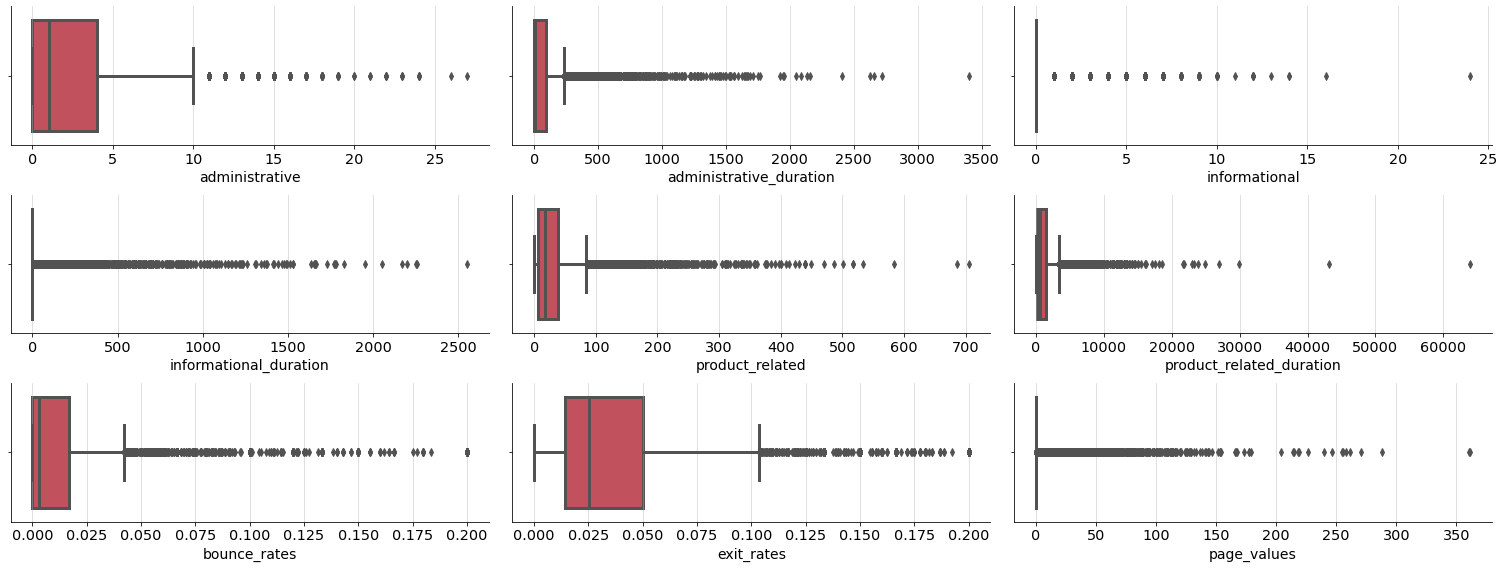

In [7]:
# boxplot
numerical.remove("special_day")
for i, col in enumerate(numerical):
    plt.subplot(3, 3, i+1)            
    sns.boxplot(
        x=df[col], 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

**Pengamatan**
* Seluruh kolom terlihat memiliki outlier yang cukup banyak dan nilai median masing-masing kolom bernilai 0 atau mendekati 0.
* Pada kolom `informational`, `informational_duration`, dan `page_values` masing-masing quantile terlalu berdekatan. Hal ini sesuai dengan descriptive statistics di atas yang menunjukkan sampai dengan 75% data masih bernilai 0.

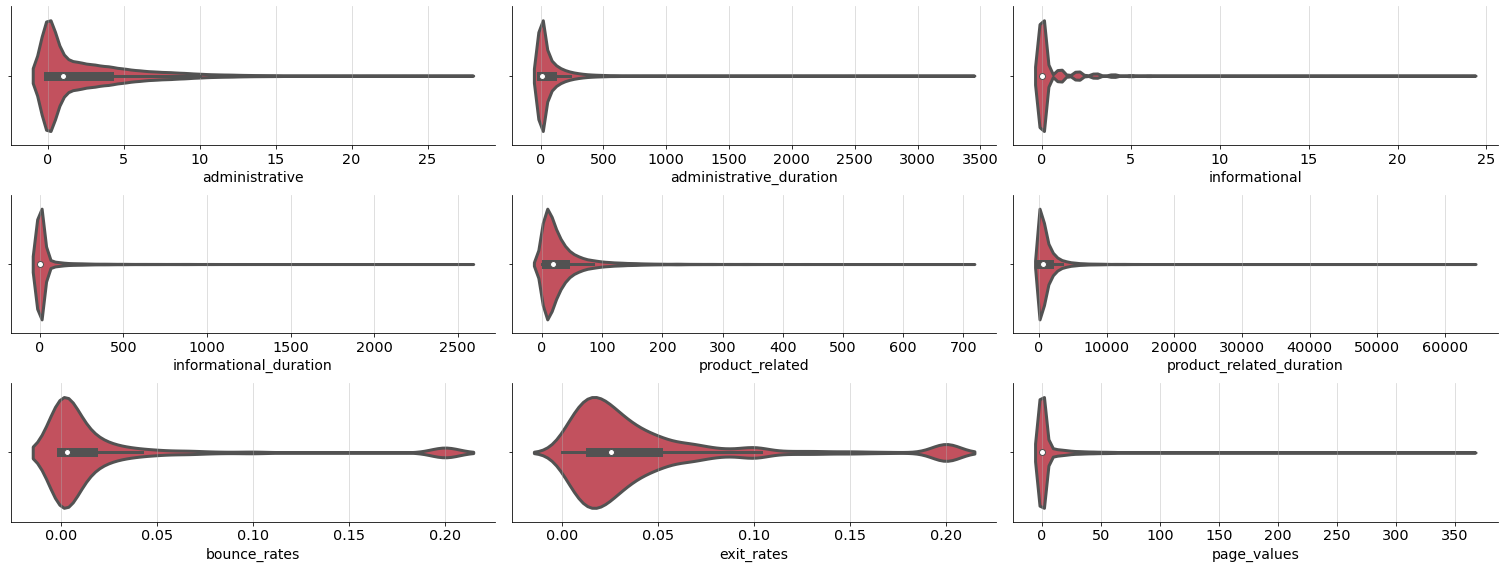

In [8]:
# violinplot
for i, col in enumerate(numerical):
    plt.subplot(3, 3, i+1)            
    sns.violinplot(
        x=df[col], 
        color=COLORS[1], 
    )
    plt.xlabel(col, fontsize=14) 
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show()            

**Pengamatan**

* Berdasarkan plot di atas, seluruh kolom numerik memiliki distribusi yang right-skewed yang mana mayoritas data bernilai 0 dan berada dekat nilai 0.
* Tidak ada kolom numerik yang memiliki distribusi mendekati normal. Namun, `bounce_rates` dan `exit_rates` memiliki distribusi mendekati log-normal.

### 1.2.2 Distribusi variabel kategorikal

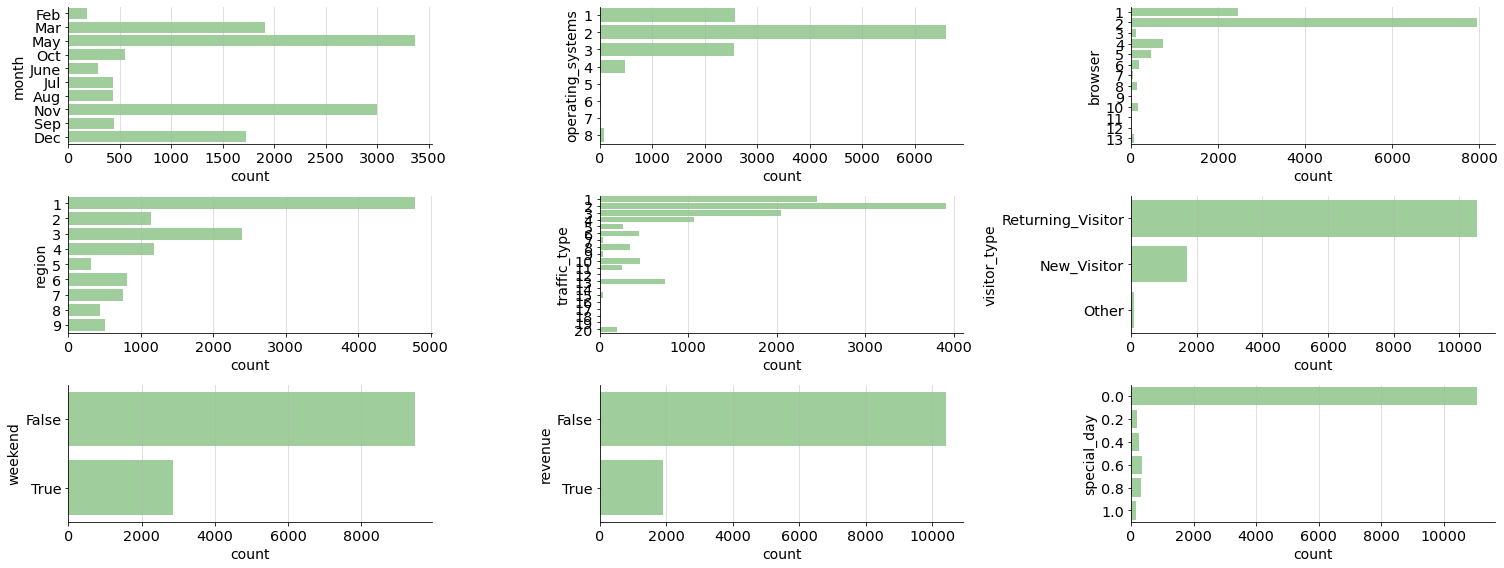

In [9]:
for i, col in enumerate(categorical):
    plt.subplot(3, 3, i+1)
    sns.countplot(
        y=df[col], 
        color=COLORS[0], 
        orient='v'
    )
    plt.xlabel("count", fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.ylabel(col, fontsize=14)
    plt.tight_layout()

plt.show()

**Pengamatan** 
* Pada kolom bulan, tidak terdapat data pada bulan `januari` dan `april`.
* Kolom `operating_system` dan `traffic_type` hanya didominasi oleh kategori 1, 2, dan 3, sedangkan kolom `browser` hanya kategori 1 dan 2.
* Kolom dengan jumlah unique value terbanyak adalah `traffic type` dan `browser`.
* Untuk kolom `visitor_type` ada jenis visitor yang tidak diketahui ditandai oleh `Other`.
* Berdasarkan target yaitu kolom revenue, terdapat hampir 2,000 pengunjung website menghasilkan revenue (15%) sedangkan lebih dari 10,000 pengunjung website tidak (85%).

### 1.2.3 Rekomendasi preprocessing berdasarkan Univariate Analysis

**1. Kolom numerik**
* Semua kolom numerik memiliki distribusi right-skewed sehingga butuh ditranformasi agar mendekati distribusi normal. 
* Beberapa **metode transformasi** yang bisa digunakan sebagai berikut:
    * log-transformer (`np.log1p`). Alasan memilih `np.log1p` dibandingkan `np.log` karena kolom numerik didominasi nilai 0. Sehingga, apabila menggunakan `np.log` maka hasil transformasi akan bernilai infinity.
    * yeo-johnson method
* Seluruh kolom numerik tidak berada di rentang yang sama sehingga harus diskala ulang atau dinormalisasi.
* Beberapa metode **normalisasi atau scaling** dari `scikit-learn` yang bisa digunakan yaitu
    * `MinMaxScaler`
    * `StandardScaler`
    * `RobustScaler`
* Outlier handling tidak diterapkan karena secara natural distribusi semua kolom numerik memang skewed.

**2. Kolom kategorikal**
* **month**: sin-cos transformation atau quarter binning. Dengan transformer ini, hubungan siklus dapat diketahui oleh algoritma machine learning.
* **operating_systems**, **browser**, **region**, **traffic_type**: ada beberapa opsi data preprocessing yaitu
    * Count encoder atau Frequency encoder
    * Rare label dan one-hot encoder. Kategori 1, 2, dan 3 akan tetap dipertahankan dan selain ketiga kategori itu akan dijadikan satu kategori yaitu `rare`. Kemudian keempat kategori tersebut di one-hot encoded.
    * Target encoder atau mean encoder. Seluruh unique value dari kolom ini diubah menjadi fraksi jumlah revenue per jumlah seluruh sesi.

* **visitor_type**, **weekend**: karena unique value hanya 2-3 saja, maka one-hot encoder bisa diterapkan.
* **revenue**: karena terdapat class imbalance dengan ratio 85:15 (majority class: minority class) maka ada beberapa cara preprocessing yang dapat digunakan sebagai berikut
    * resampling (oversampling, undersampling, atau over-under sampling) agar ratio majority terhadap minority class menjadi 50:50
    * memberi class weight yang lebih tinggi ke minority class saat modeling
    
Referensi
* [Transformation & Scaling Numeric Features Intuition](https://towardsdatascience.com/transformation-scaling-of-numeric-features-intuition-7f4436e8e074#:~:text=If%20dependent%20features%20are%20transformed,should%20be%20applied%20after%20transformation)

## 1.3 Multivariate Analysis

### 1.3.1 Feature numerik vs label revenue

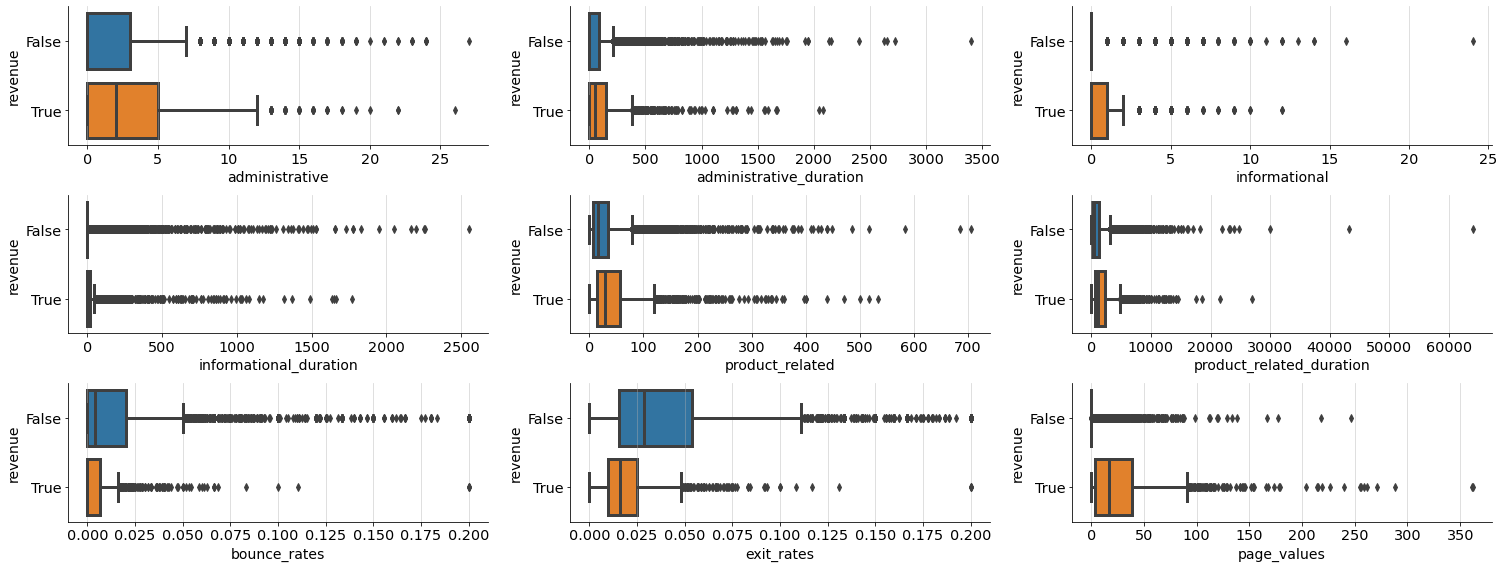

In [10]:
# boxplot
for i, col in enumerate(numerical):
    plt.subplot(3, 3, i+1)
    sns.boxplot(
        y=df['revenue'], 
        x=df[col], 
        orient='h'
    )
    plt.xlabel(col, fontsize=14)
    plt.ylabel('revenue', fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show()

**Pengamatan**
* Pengunjung website mengunjungi halaman web product related lebih banyak dibandingkan dengan halaman administratif dan information.
* Pengunjung yang menghasilkan revenue cenderung lebih lama mengakses halaman web product related.
* Pengunjung dengan bounce rates yang lebih rendah, exit rates yang lebih rendah, dan page values yang lebih tinggi cenderung menghasilkan revenue.


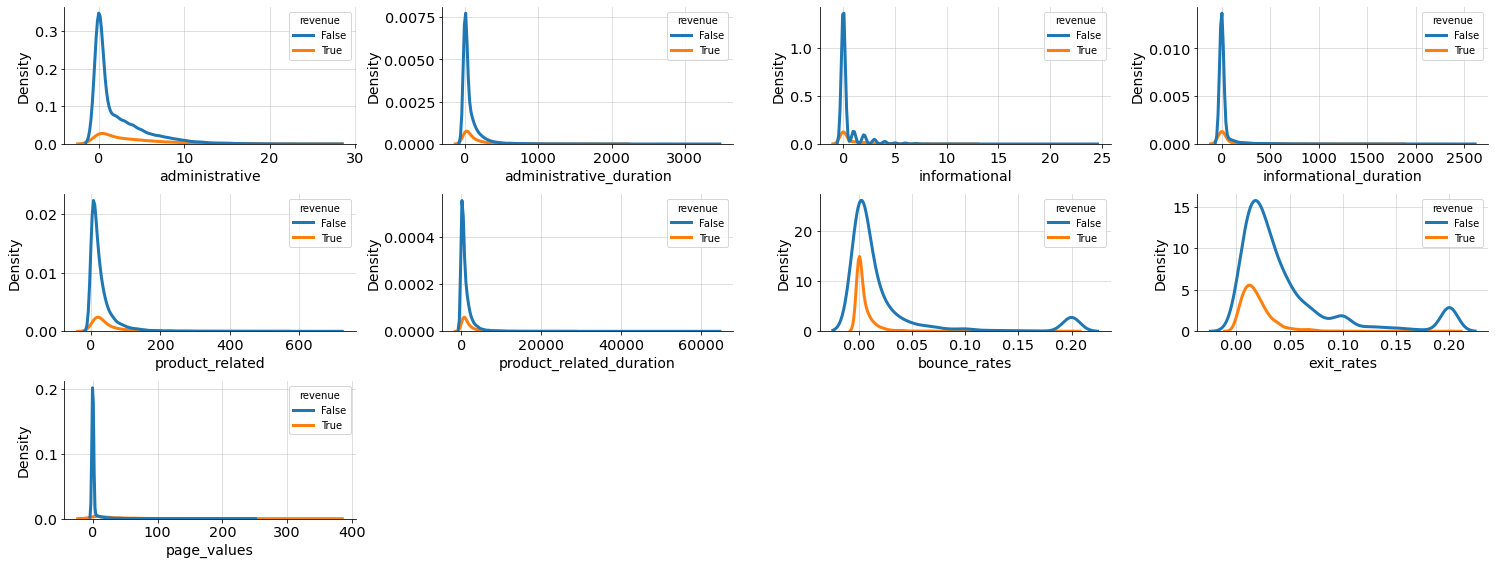

In [11]:
# kdeplot
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(
        x=df[col],
        hue=df['revenue'],
    )
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()

plt.show()

**Pengamatan**
* Pada kolom `exit_rates` terlihat untuk jumlah transaksi yang menghasilkan revenue, nilai `exit_rates` cenderung rendah dengan data terbanyak tersebar di rentang 0 - 0.05. 
* Sedangkan pada `bounce_rates`, jumlah transaksi yang menghasilkan revenue cukup signifikan di rentang 0.00 - 0.01.
* Pada kolom `page_values`, di rentang 0 - 100, jumlah transaksi yang menghasil revenue cukup tinggi.

### 1.3.2 Feature kategorikal vs label revenue

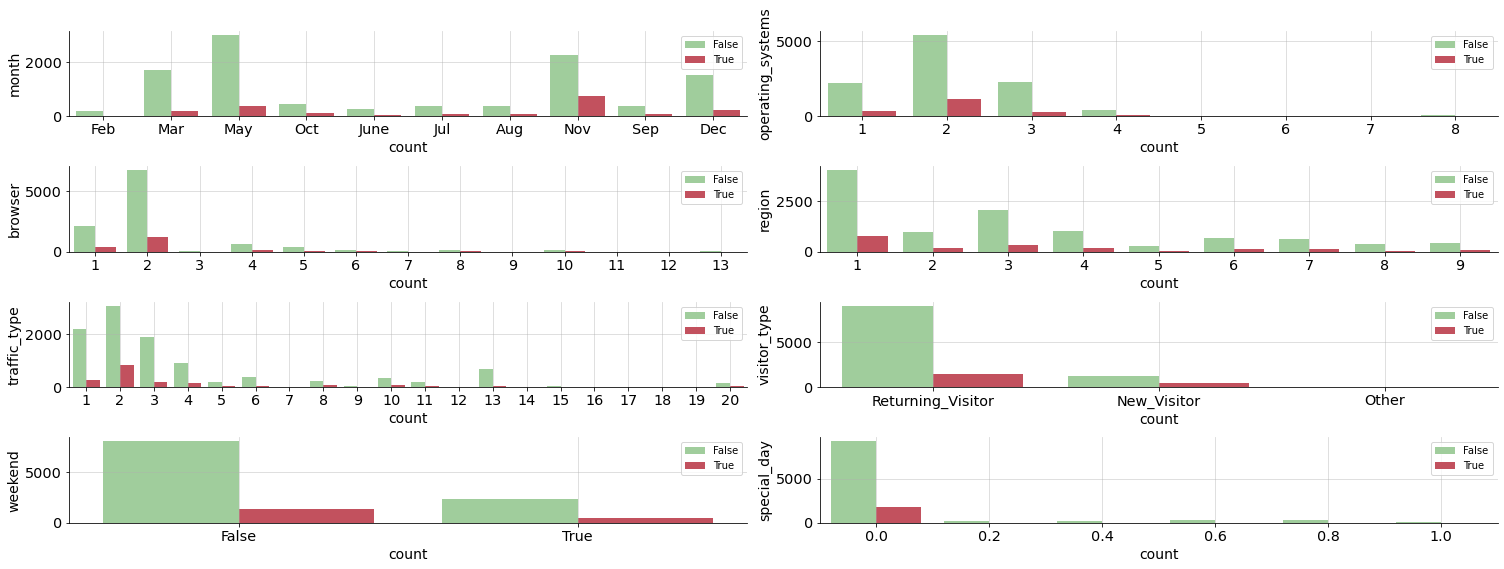

In [12]:
categorical.remove('revenue')
for i, col in enumerate(categorical):
    plt.subplot(4, 2, i+1)
    sns.countplot(
        x=df[col], 
        palette=COLORS, 
        orient='h',
        hue=df['revenue']
    )
    plt.xlabel("count", fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()

plt.show()

**Pengamatan**
* Jumlah pengunjung website yang menghasilkan revenue terbanyak pada bulan November dan terendah pada bulan Februari dan Juni. 
* Pengunjung website yang menghasilkan revenue mayoritas menggunakan browser dan OS tipe 2.
* Sumber traffic yang paling banyak menghasilkan revenue adalah traffic type 2.
* Returning visitor banyak yang tidak melakukan transaksi yang menghasilkan revenue.
* Pengunjung website lebih banyak bertransaksi di weekday daripada di weekend.

### 1.3.3 Analisis Korelasi

Analisis korelasi memiliki tujuan untuk mengetahui korelasi antar feature serta korelasi antara feature terhadap label. Berikut ini cara untuk menemukan korelasi setiap pasangan tipe variabel yang akan diuji:
1. **Feature Numerik - Feature Numerik**: spearman's correlation
2. **Feature Numerik - Label Kategorikal**: mann-whitney u test
3. **Feature Kategorikal - Label Kategorikal**: chi-square test

Referensi
* [Exploratory Data Analysis for Feature Selection, Google Cloud](https://drive.google.com/file/d/1Xt7kTxT0kQwALgvvstZ-N4MKH9dFOS9I/view?usp=sharing)
* [Spearman's rho](https://www.statstest.com/spearmans-rho/#Monotonicity)
* [Mann-whitney U test](https://www.statstest.com/mann-whitney-u-test/)
* [Chi-square test](https://www.statstest.com/chi-square-test-of-independence/)

#### Korelasi antar feature numerik

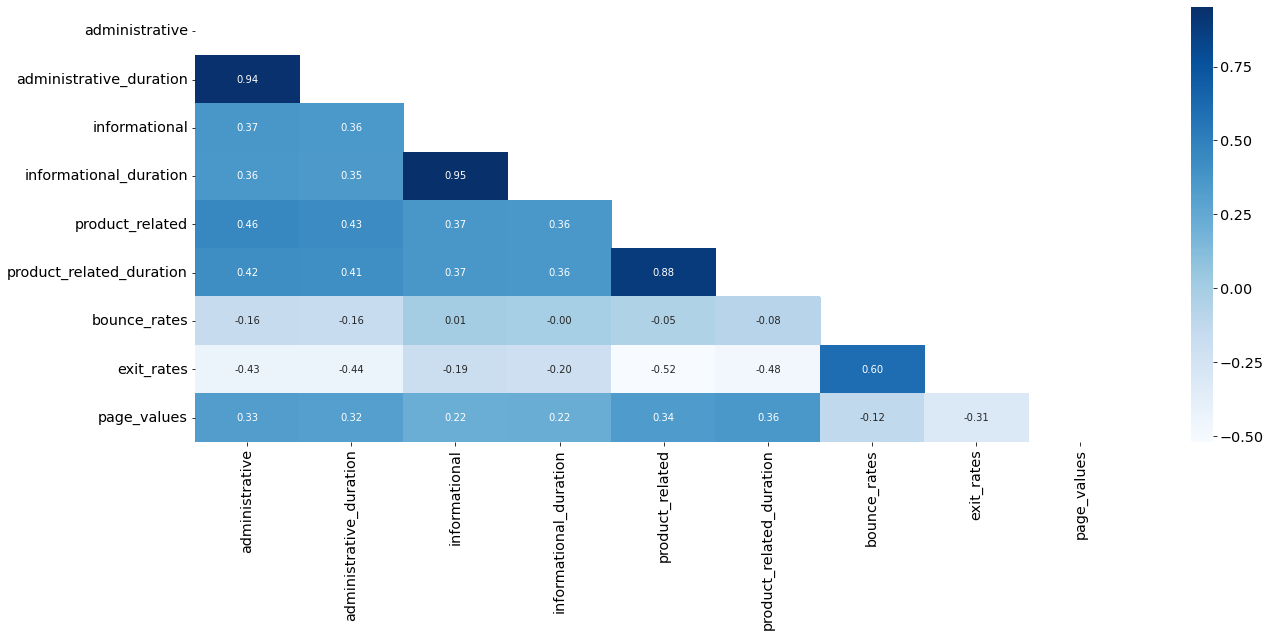

In [13]:
data = df[numerical].corr(method='spearman')
sns.heatmap(
    data, 
    mask=np.triu(np.ones_like(data)),
    cmap='Blues', 
    annot=True, 
    fmt='.2f',
)
sns.set(font_scale=3) 
plt.show()

**Pengamatan**
* Kolom jumlah page dan jumlah durasi page memiliki korelasi yang tinggi yaitu 0.88 - 0.95.
* Kolom-kolom numerik yang berkorelasi  sangat tinggi harus ditinggalkan salah satunya. 
* Selain keempat kolom tersebut, korelasi antar feature numerik dibawah 0.8.

#### Korelasi antara feature numerik dan label

Sebagai catatan, karena label (target variabel) bertipe kategori, maka korelasi pearson antara feature numerik dan label tidak dapat merepresentasikan korelasi yang sebenarnya. Cara yang tepat untuk menemukan korelasi antara kolom numerik yang memiliki distribusi skewed terhadap kolom kategori adalah dengan menggunakan **Mann-Whitney U test**. Kemudian, p-value dari hasil test digunakan untuk menentukan korelasi antar variabel.

Berikut ini null hypothesis dan alternative hypothesis yang digunakan t-test. Nilai signifikan (alpha) yang ditetapkan adalah 0.05:
* Null hypothesis **(H0)**: feature dan label **independen**
* Alternative hypothesis **(H1)**: feature dan label **tidak independen**

Hasil U test sebagai berikut.

In [14]:
def mann_whitney_utest(df, numerical, target='revenue'):
    df = df.copy()
    numerical.append("special_day")

    # initialize dataframe for storing test results
    num_features = pd.DataFrame(np.empty((10, 3)))
    num_features.columns = ['categorical', 'group_1', 'group_2']
    num_features['categorical'] = target
    num_features['group_1'] = 'False'
    num_features['group_2'] = 'True'
    num_features['numerical'] = numerical

    # group by revenue class (True and False)
    group_1 = df.groupby('revenue').get_group(False).reset_index(drop=True)
    group_2 = df.groupby('revenue').get_group(True).reset_index(drop=True)

    # two sampled t-test
    results = []
    for num in numerical:
        a = group_1[num]
        b = group_2[num]
        
        results.append(stats.mannwhitneyu(a, b))
    
    # t-test results
    results = pd.DataFrame(results)
    results.columns = ['statistic', 'p_value']

    return pd.concat([num_features, results], axis=1)

mann_whitney_utest(df, numerical).sort_values(by='p_value').reset_index(drop=True)

,categorical,group_1,group_2,numerical,statistic,p_value
0,revenue,False,True,page_values,2718419.0,0.000000e+00
1,revenue,False,True,exit_rates,5903869.0,5.784121e-176
2,revenue,False,True,product_related_duration,6502463.0,2.666134e-128
3,revenue,False,True,product_related,6792127.0,5.262193e-108
4,revenue,False,True,administrative,7421135.5,6.559659e-78
5,revenue,False,True,administrative_duration,7487115.0,2.336130e-74
6,revenue,False,True,bounce_rates,7686683.0,9.163850e-62
7,revenue,False,True,informational,8648742.0,6.013907e-37
8,revenue,False,True,informational_duration,8711649.0,7.045193e-36
9,revenue,False,True,special_day,9220133.0,2.539780e-22


**Pengamatan**
* Dari hasil U-test di atas, seluruh kolom memiliki p_value yang lebih kecil dari alpha (**p_value < alpha**) sehingga semua kolom numerik memiliki korelasi terhadap label revenue.
* `page_values`, `exit_rates`, `product_related_duration`, dan `product_related` memiliki korelasi paling tinggi di antara seluruh kolom numerik.

#### Korelasi antara feature kategorikal dan label

Berikut ini hypothesis yang digunakan chi-square test dengan nilai signifikan (alpha) yang ditetapkan 0.05.
* Null hypothesis **(H0)**: feature dan label **independen**
* Alternative hypothesis **(H1)**: feature dan label **tidak independen**

Hasil chi-square test sebagai berikut.

In [15]:
def chi_square_test(df, cat1='operating_systems', cat2='revenue'):
    # create a contigency table for input of chi-square test
    table = pd.crosstab(df[cat1], df[cat2])

    # perform the chi-square test
    chi_stats, p_value, dof, exp_val = stats.chi2_contingency(table) 

    return chi_stats, p_value, dof, exp_val

def test_results(df, categorical, target='revenue'):
    # remove revenue from categorical list
    cat_features = categorical.copy()
    
    if target in categorical:
        cat_features.remove(target)
        cat_features.remove("special_day")
    
    # chi-square test
    test = []
    for feature in cat_features:
        test.append((chi_square_test(df, cat1=feature, cat2=target)))
    
    # store the test results to dataframe
    cat_df = pd.DataFrame()
    cat_df['cat1'] = cat_features
    cat_df['cat2'] = target
    
    results = pd.DataFrame(test).drop(3, axis=1)
    results.columns = ['chi_stats', 'p_value', 'dof']

    results['association'] = np.nan
    for i, p_val in enumerate(results['p_value']):
        if p_val < 0.05:
           results.loc[i, 'association'] = 'dependent'
        else:
           results.loc[i, 'association']  = 'independent'
           
    return pd.concat([cat_df, results], axis=1)

test_results(df, categorical).sort_values(by='p_value').reset_index(drop=True)

,cat1,cat2,chi_stats,p_value,dof,association
0,month,revenue,384.934762,2.238786e-77,9,dependent
1,traffic_type,revenue,373.145565,1.652735e-67,19,dependent
2,visitor_type,revenue,135.251923,4.269904e-30,2,dependent
3,special_day,revenue,96.076906,3.543244e-19,5,dependent
4,operating_systems,revenue,75.027056,1.416094e-13,7,dependent
5,weekend,revenue,10.390978,1.266325e-03,1,dependent
6,browser,revenue,27.715299,6.087543e-03,12,dependent
7,region,revenue,9.252751,3.214250e-01,8,independent


**Pengamatan**
* Berdasarkan hasil chi-square test, `region` tidak memiliki korelasi terhadap `revenue` sehingga bisa di-drop saat modelling karena hanya `region` yang memiliki p-value diatas alpha 0.05.
* Apabila melihat p-value maka kolom kategorikal yang memiliki korelasi paling tinggi adalah `month`, `traffic_type`, dan `visitor_type`

### Kesimpulan Multivariate Analysis

**A. Bagaimana korelasi antara masing-masing feature dan label. Kira-kira feature mana saja yang paling relevan dan harus dipertahankan?**
* Berdasarkan analisis korelasi semua kolom numerik dan kategorikal memiliki korelasi ke target kecuali feature `region`. Berikut ini adalah 3 feature dari masing-masing tipe kolom yang paling tinggi nilai korelasi terhadap target.
    * Numerik: `page_values`, `exit_rates`, dan `product_related_duration`
    * Kategorikal: `month`, `traffic_type`, dan `visitor_type`

**B. Bagaimana korelasi antar-feature, apakah ada pola yang menarik? Apa yang perlu dilakukan terhadap feature itu?**

* Berdasarkan spearman's correlation yang ditunjukkan oleh heatmap, ada korelasi antar feature numerik yang significant di atas 0.8 yaitu kolom jumlah page dan jumlah durasi page memiliki korelasi yang tinggi yaitu 0.88 - 0.95.

* Karena terdapat korelasi tinggi antar feature numerik dan ada feature kategorikal yang tidak berkorelasi ke label maka 
  * Salah satu dari pasangan kolom numerik yang berkorelasi tinggi harus didrop
  * Kolom region bisa didrop


## 1.4 Business Insight

Dari data yang tersedia, secara teori sebenarnya hampir semua variabel bisa memiliki pengaruh terhadap jumlah pengunjung website yang menghasilkan revenue. Sayangnya, beberapa variabel bertipe integer tidak ada ada tabel acuannya (contoh: `traffic_type`, `operating_system`, dll) sehingga tidak bisa semuanya dijadikan insight yang mendetail.


#### 1.4.1 Insight from Bounce Rates

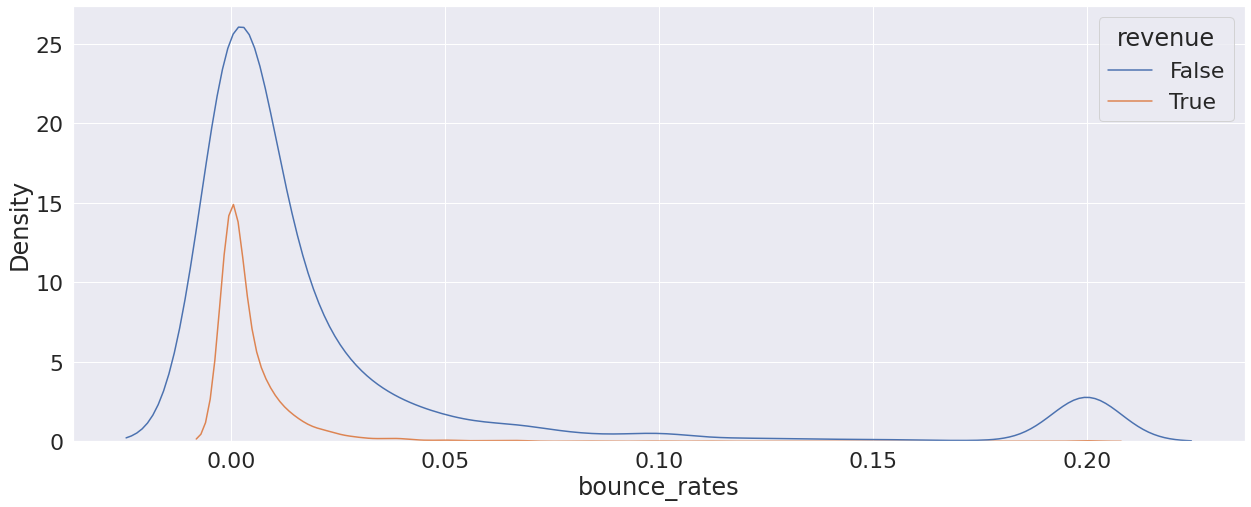

In [16]:
sns.set(font_scale=2) 
sns.kdeplot(x='bounce_rates', hue='revenue', data=df);

Bounce rate yang tinggi pada halaman ecommerce, secara umum akan menghasilkan revenue yang sedikit. Untuk ecommerce, bounce rate dibawah 20% atau diatas 90% dapat menjadi tanda bahwa ada hal yang tidak beres. Ketika bounce rate terlalu rendah, bisa saja disebabkan masalah pada analytics setup. Sementara bounce rate yang terlalu tinggi, bisa jadi pertanda bahwa site ecommerce tidak memiliki performance yg baik [(reference)](https://www.softformance.com/blog/bounce-rate/#:~:text=For%20the%20most%20part%2C%20bounce,offering%20a%20poor%20user%20experience.).

Pengunjung yang menghasilkan revenue cenderung memiliki bounce rate yang lebih rendah dibandingkan yang tidak menghasilkan revenue yang mana sesuai dengan reference dan teori secara umum. Namun, apabila dilihat secara keseluruhan, rata-rata dan median bounce rate rendah: 0.3-2.3% dan nilai max 20% sedangkan persentase jumlah pengunjung yang menghasilkan revenue sangat kecil sekitar 15% dari seluruh total pengunjung.

**Rekomendasi**: Lakukan pengecekan terhadap analytics setup, apakah ada kesalahan setting sehingga ada bounce rate yang tidak terdeteksi.

#### 1.4.2 Insight from Exit Rates

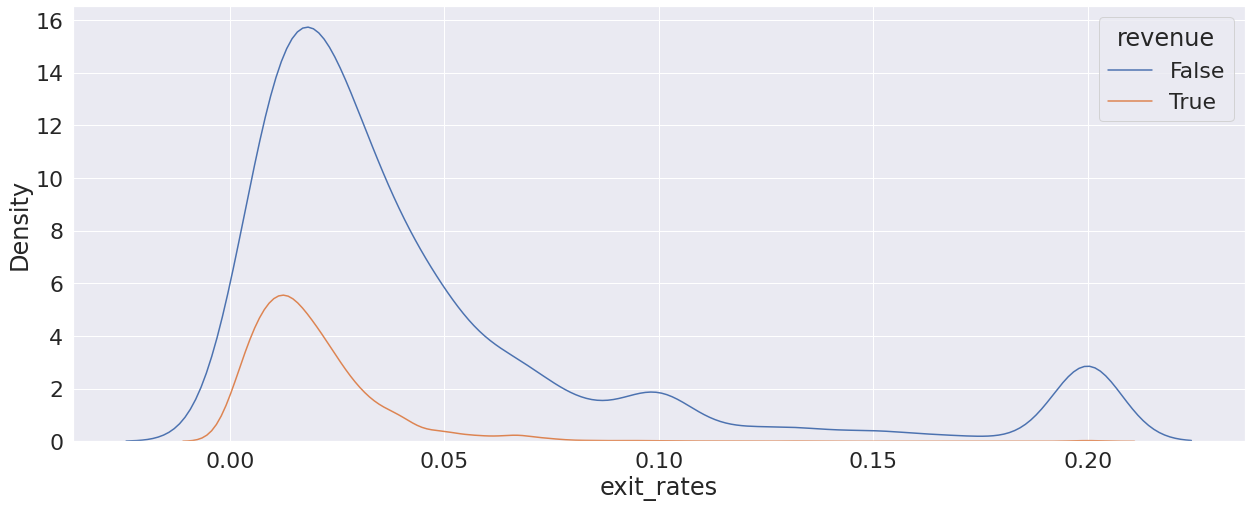

In [17]:
sns.set(font_scale=2) 
sns.kdeplot(x='exit_rates', hue='revenue', data=df);

Exit Rates adalah persentase ketika visitor keluar dari website kita dari page/halaman tertentu (halaman terakhir sebelum visitor meninggalkan website kita). Exit rate yang tinggi pada sebuah halaman spesifik dapat menjadi pertanda ada yg salah dengan halaman tersebut terutama high exit rate pada halaman check-out atau halaman produk. Tetapi, ada pengecualian pada halaman-halaman tertentu, Sebagai contoh pada Thank you Page, setelah transaksi, exit rate tinggi bisa jadi termasuk hal yang normal [(reference)](https://www.americaneagle.com/insights/blog/post/2021/05/11/conversion-rate-optimization-understanding-your-exit-rate).

Exit rate secara langsung terkait dengan bounce rate, karena parameter bagi keduanya adalah ketika visitor meninggalkan website [(reference)](https://support.google.com/analytics/answer/2525491?hl=en#:~:text=For%20all%20pageviews%20to%20the,that%20start%20with%20that%20page.). Benchmark hampir sama dengan bounce rate yang mana dibawah 20% terlalu rendah dan diatas 90% terlalu tinggi.

Jumlah pengunjung yang menghasilkan revenue cenderung memiliki exit rate yang lebih rendah dibandingkan yang tidak menghasilkan revenue yang mana sesuai dengan reference dan teori secara umum. Rata-rata dan median exit rate rendah: 2.5-4% , max values nya juga 20%. 

**Rekomendasi**: Pengecekan ke analytics setup sudah benar atau belum.

#### 1.4.3 Insight from Product Related

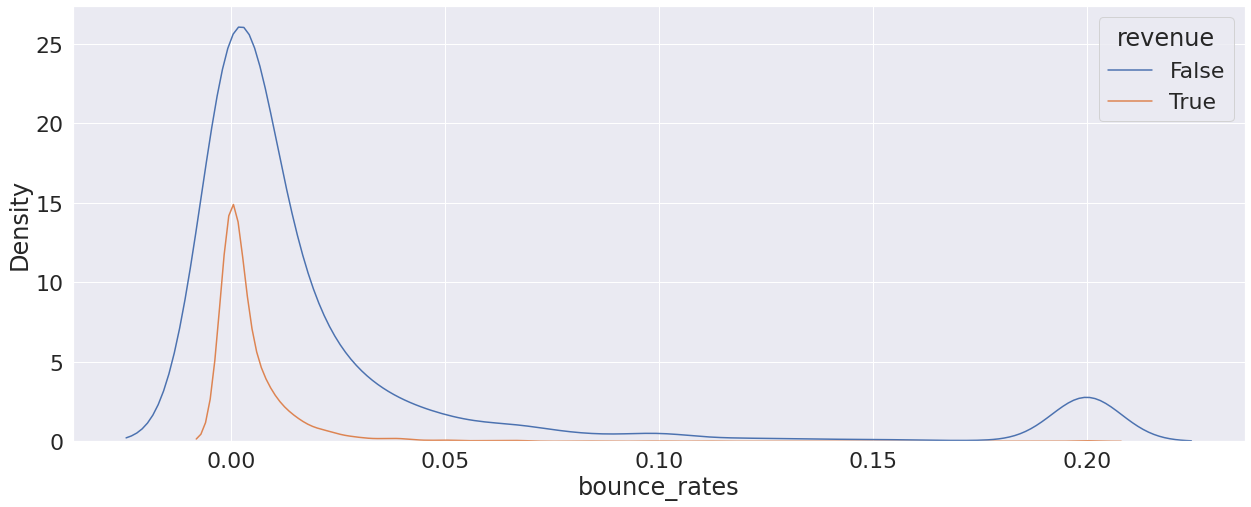

In [18]:
sns.set(font_scale=2) 
sns.kdeplot(x='bounce_rates', hue='revenue', data=df);

Secara general, visitor yang mengunjungi pages bertipe product related memiliki intensi membeli yang lebih tinggi atau sedang dalam tahap membuat decision untuk membeli. Product page yang menghasilkan hanya sedikit revenue dapat mengindikasikan bahwa product page tersebut tidak mendemonstrasikan produk dengan baik atau secara interface juga tidak cukup membuat user betah dipage tersebut [(reference)](https://optinmonster.com/reasons-your-ecommerce-site-has-a-low-conversion-rate/).

Diantara semua jenis page (product page, administrative, informational), product page adalah yang jumlahnya paling banyak dan paling lama dikunjungi oleh visitor. (90% dari total kunjungan dan durasi kunjungan semua page).

Bila dilihat pun dari seluruh transaksi dengan revenue, sebagian besar adalah berasal dari visit ke product page.
Tetapi 90% total kunjungan page dibandingkan dengan 15% sesi yang menghasilkan conversion, terbilang rendah.

**Rekomendasi**: Lakukan pengecekan terhadap product related page dari segi interface, kemudahan akses, kejelasan informasi dan demonstrasi produk, dll. Apakah high product page visit tapi low conversion disebabkan oleh hal-hal tersebut.

#### 1.4.4 Insight from Page Values

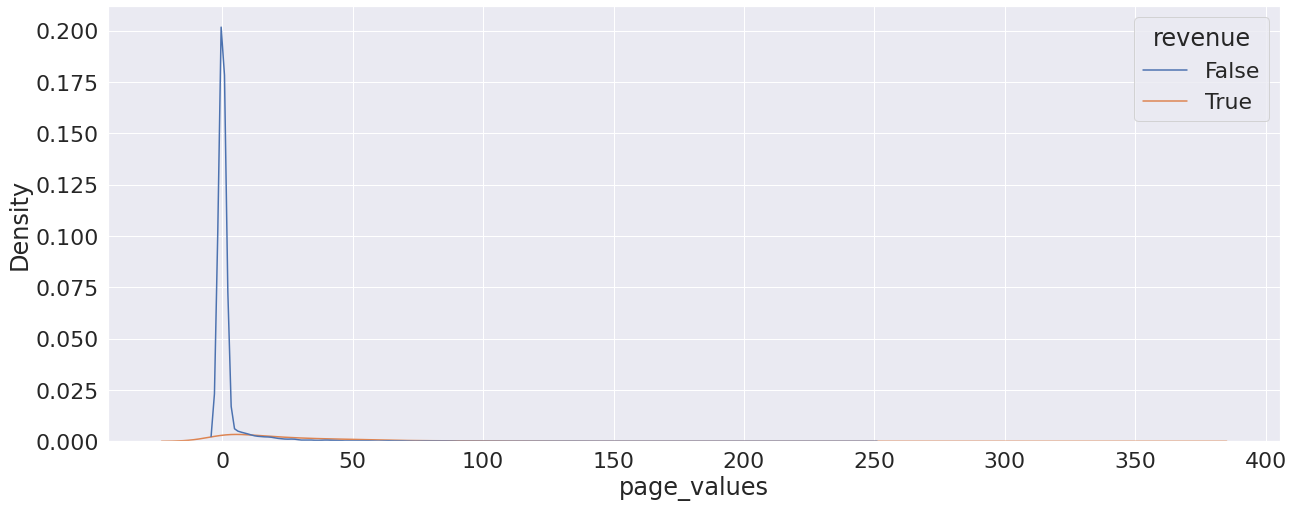

In [19]:
sns.set(font_scale=2) 
sns.kdeplot(x='page_values', hue='revenue', data=df);

Nilai page value yang tinggi menunjukkan page mana yang lebih attractive dimata visitor, dengan mengetahui page yang memiliki high value tinggi, kita bisa memusatkan page tersebut untuk generate lebih banyak revenue (reference). Sesi yang menghasilkan pendapatan cenderung memiliki page value yang lebih tinggi dibandingkan yang tidak menghasilkan revenue yang mana sesuai dengan reference dan teori secara umum [(reference)](https://betterstudio.com/blog/page-value-in-google-analytics/#what-is-page-value).

Apabila dilihat secara keseluruhan, nilai page value sangat skewed. Hampir seluruh nilainya sangat kecil yang apabila dilihat dari statistik deskriptif, hingga 75% data masi bernilai 0 yang berarti banyak sekali page yang tidak cukup ‘menarik’ bagi visitor.

**Rekomendasi**: Memperbaiki kualitas konten di website agar lebih menarik.

# Stage 2 - Data Preprocessing

## 2.1. Data Cleansing

Berikut ini strategi untuk data cleansing berdasarkan hasil EDA sebelumnya. Namun, sebelum memulai untuk memanipulasi seluruh feature, dataset dibagi menjadi dua yaitu train set dan test set dengan ratio 80:20.

1. Data duplikasi sebanyak 125 rows di-drop dari seluruh dataset.
2. Outliers pada feature numerik tidak dihapus tetapi jumlahnya dikurangi dengan feature transformation. Feature transformation yang tepat digunakan yaitu:
    * Log-transformation menggunakan `np.log1p`.
    * Power-transformation menggunakan yeo-johnson transformer.
3. Agar feature numerik memiliki range yang sama atau memiliki mean dan standar deviasi yang hampir sama, maka beberapa feature scaling yang tepat digunakan yaitu:
    * MinMaxScaler untuk membuat seluruh feature numerik menjadi di range 0 hingga 1.
    * StandardScaler untuk membuat seluruh feature numerik memiliki mean 0 dan standar deviasi 1.
    * RobustScaler yang men-scale data berdasarkan median dan IQR.
4. Untuk feature kategorikal, perlu feature encoding agar tipe string dapat diubah menjadi tipe int atau float. Berikut ini strategi feature enconding:
    * Sin-cos transformation atau Quarter binning untuk kolom `month`
    * One-hot encoding untuk `visitor_type` dan `weekend` karena jumlah unique value tidak banyak sekitar 2-3.
    * Untuk `operating_systems`, `browser`, `region`, dan `traffic_type` bisa menggunakan
        * Count encoder
        * Frequency encoder
        * target encoder
        * rare-label encoding + one-hot enconding
5. Karena kolom target memiliki class imbalance dengan ratio 85:15 maka berikut cara yang tepat untuk menanganinya
    * Melakukan resampling (oversampling, undersampling, or over-undersampling) agar distribusi target menjadi 50:50.
    * Memberi class weight lebih besar pada minority class dari kolom target
    * Menggunakan metrik evaluasi model yang tepat seperti precision, recall, f1-score, dan metrik tambahan seperti ROC-AUC

### 2.1.1 Handle missing values

In [20]:
df.isnull().sum().sum()

0

Missing values tidak terdapat pada dataset sehingga tidak ada yang perlu di-handle.

### 2.1.2 Handle duplicated data

In [21]:
df.duplicated().sum()

125

In [22]:
df[df.duplicated(keep=False)].reset_index(drop=True).head()    # show the first five rows of duplicated data

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,3,Returning_Visitor,False,False
1,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False
4,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False


In [23]:
df[df.duplicated(keep='last')]         # show last duplicated data

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
85,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,3,Returning_Visitor,False,False
132,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False
159,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,3,2,3,3,Returning_Visitor,False,False
252,0,0.0,0,0.0,2,0.0,0.2,0.2,0.0,0.0,Mar,1,1,1,1,Returning_Visitor,False,False
286,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Nov,3,2,1,13,Returning_Visitor,False,False
11205,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,8,13,9,20,Other,False,False
11581,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,8,13,9,20,Other,False,False
11801,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Dec,1,1,4,1,Returning_Visitor,True,False


Pada dataset ini terdapat duplicated data sebanyak 125. Walaupun seluruh data merupakan data yang berbeda di setiap visitor, duplicated data harus tetap di drop karena model machine learning tidak dapat mendeteksi perbedaan setiap rows.


In [24]:
print(f"jumlah rows dengan data duplikasi: {df.shape}")

df = df.drop_duplicates()
print(f"jumlah rows tanpa data duplikasi: {df.shape}")

jumlah rows dengan data duplikasi: (12330, 18)
jumlah rows tanpa data duplikasi: (12205, 18)


### 2.1.3 Handle outliers & Feature Transformation

Feature-feature numerik di dataset ini memiliki distribusi right-skewed sehingga terlihat jelas outliers yang ada. Namun, karena mayoritas data banyak yang bernilai 0, outliers tidak akan dihapus tetapi akan dikurangi jumlahnya dengan menggunakan log-transformer atau power-transformer. Berikut ini transformer yang akan digunakan.

* `np.log1p`: log(x+1)
* yeo-johnson transformation

Referensi
* [Yeo-johnson](https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/)

#### Kondisi feature numerik sebelum log-transformation

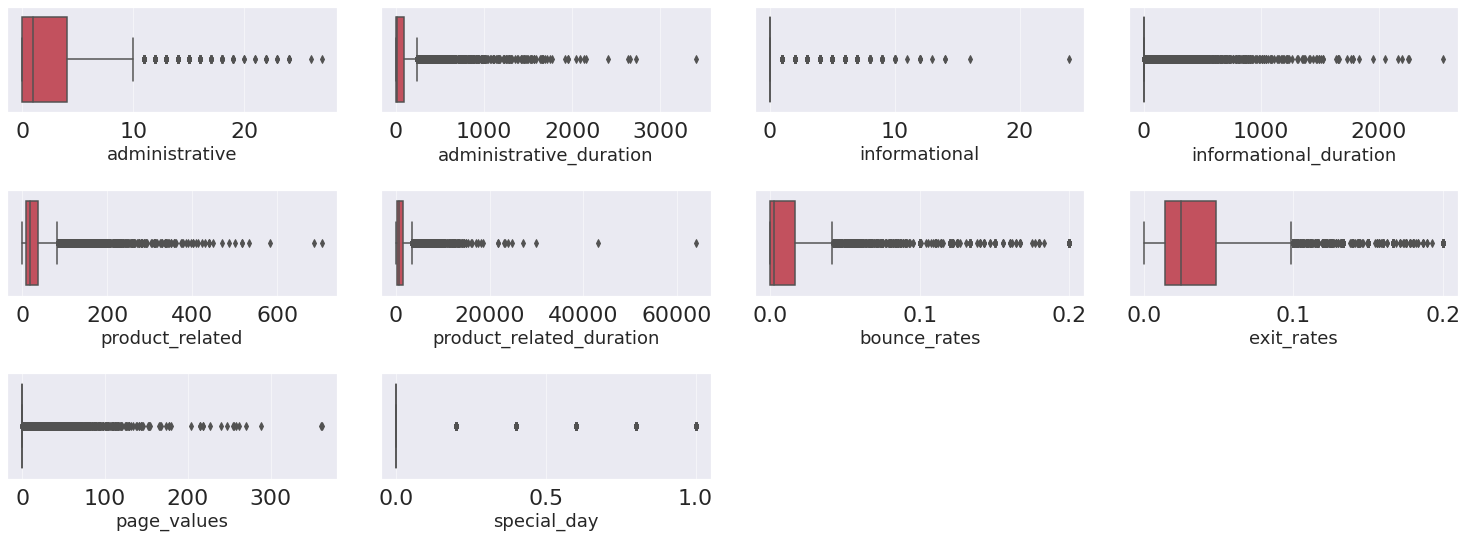

In [25]:
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)            
    sns.boxplot(
        x=df[col], 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=18)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

#### Kondisi feature numerik sesudah log-transformation dengan `np.log1p`

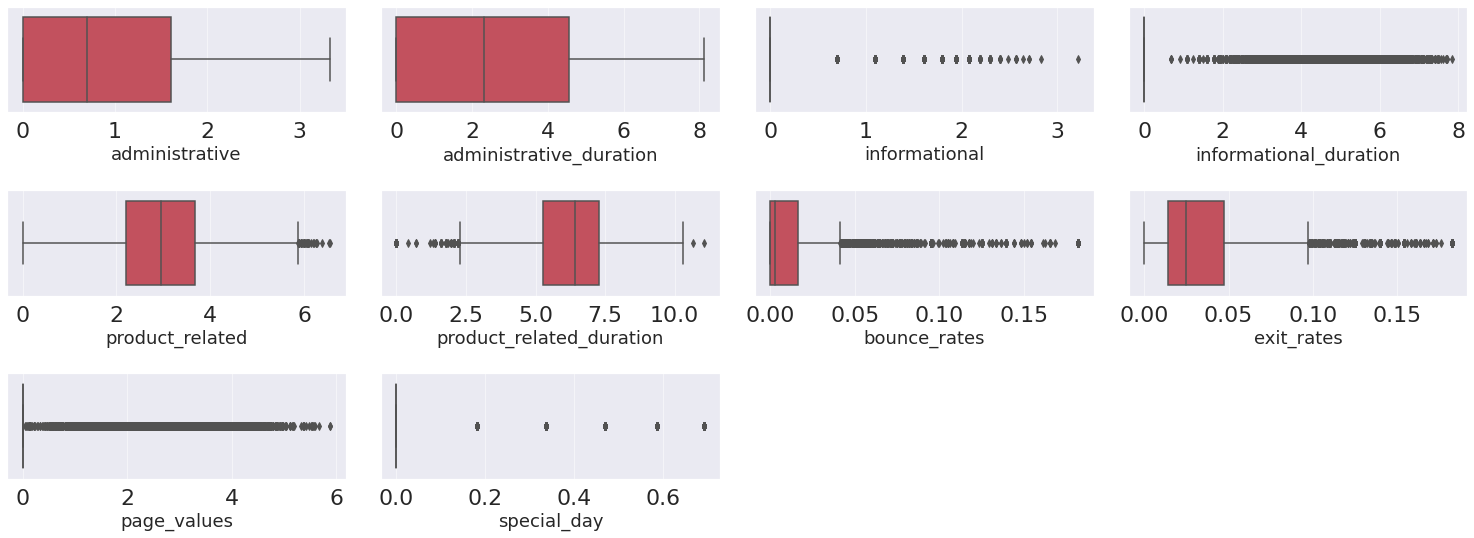

In [26]:
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)            
    sns.boxplot(
        x=np.log1p(df[col]), 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=18)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

**Pengamatan**
* Kolom yang outliernya berkurang atau bahkan hilang yaitu `administrative`, `administrative_duration`, `product_related`, dan `product_related_duration`. Namun, selain keempat kolom tersebut `np.log1p` transformer tidak memberi dampak apa-apa terhadap distribusi.

#### Kondisi feature numerik sesudah transformation dengan yeo-johnson

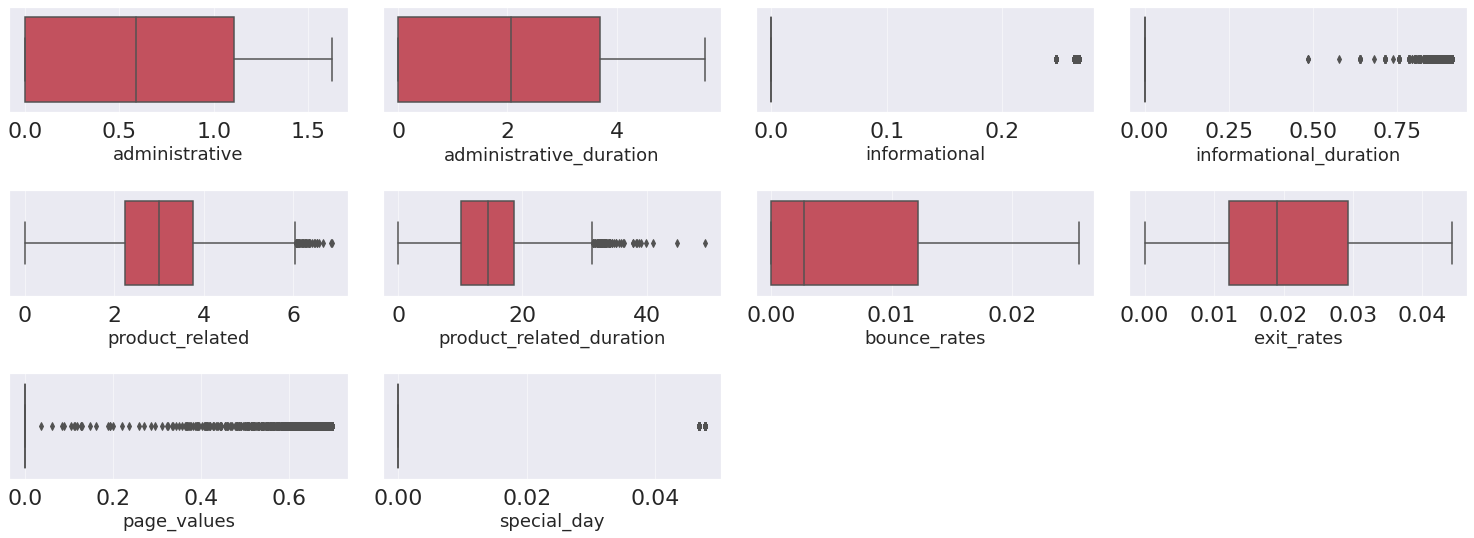

In [27]:
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)            
    sns.boxplot(
        x=stats.yeojohnson(df[col].astype('float64'))[0], 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=18)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

**Pengamatan**
* kolom `bounce_rates` dan `exit_rates` tidak memiliki outlier lagi setelah yeo-johnson transformer.

#### Kesimpulan log- transformation
1. Kolom `administrative` dan `administrative_duration` tidak memiliki outliers setelah ditransformasi dengan `np.log1p` dan yeo-johnson.
2. Kolom `bounce_rates` dan `exit_rates` lebih cocok ditransformasi dengan yeo-johnson karena setelah transformasi outliers tidak ada.
3. Untuk kolom `product_related` dan `product_related_duration`, menggunakan kedua transformer tersebut dapat mengurangi outliers secara signifikan.
4. Kolom `informational`, `informational_duration`, `page_values`, dan `special_day` tidak berubah distribusinya setelah transformation. Hal ini terjadi karena
    * Kolom `informational`, `informational_duration`, `page_values` memiliki data yang mayoritas tersebar di dekat nol sehingga saat ditransform dengan `np.log1p` atau yeo-johnson, nilai-nilai yang besar tetap jauh dari nilai 0.
    * Kolom `special_day` hanya memiliki 6 unique values yang mana lebih tepat di-treat sebagai kolom kategorikal. Namun, kolom `special_day` kemungkinan tidak memberi impak ke model karena 89% data memiliki nilai 0.
 
5. Jadi, karena setelah mencoba mentransform dengan kedua transformer tersebut hanya ada empat feature yang outliers hilang, maka untuk tahap modelling akan lebih fokus menggunakan algoritma machine learning yang robust terhadap outlier seperti tree-based classifier dan ensemble classifier.

### 2.1.4 Feature Normalization and Scaling

Apabila model yang digunakan linear seperti Logistic Regression, maka semua feature harus berada salah satu kondisi dibawah ini 
1. **range yang sama** dengan menggunakan `MinMaxScaler` untuk menskala ulang feature numerik menjadi di range 0 hingga 1.

2. **memiliki mean 0 dan standar deviasi 1**. Kondisi ini dicapai dengan menggunakan `StandardScaler`.

3. jika terdapat banyak outliers, ada kemungkinan scaling menggunakan mean dan variance tidak terlalu membantu meningkatkan performa model. Oleh karena itu, scaling harus menggunakan **median dan IQR** dengan `RobustScaler`

Referensi
* [Preprocessing data, Scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)

#### Statistik deskriptif feature numerik sebelum normalisasi atau scaling

In [28]:
desc_nums = df[numerical].describe().round(3).T
desc_nums

,count,mean,std,min,25%,50%,75%,max
administrative,12205.0,2.339,3.330,0.0,0.000,1.000,4.000,27.000
administrative_duration,12205.0,81.646,177.492,0.0,0.000,9.000,94.700,3398.750
informational,12205.0,0.509,1.276,0.0,0.000,0.000,0.000,24.000
informational_duration,12205.0,34.825,141.425,0.0,0.000,0.000,0.000,2549.375
product_related,12205.0,32.046,44.594,0.0,8.000,18.000,38.000,705.000
product_related_duration,12205.0,1206.982,1919.601,0.0,193.000,608.943,1477.155,63973.522
bounce_rates,12205.0,0.020,0.045,0.0,0.000,0.003,0.017,0.200
exit_rates,12205.0,0.041,0.046,0.0,0.014,0.025,0.049,0.200
page_values,12205.0,5.950,18.654,0.0,0.000,0.000,0.000,361.764
special_day,12205.0,0.062,0.200,0.0,0.000,0.000,0.000,1.000


#### MinMaxScaler

In [29]:
def data_scaling(df, numerical, scaler):
    df = df.copy()
    
    # apply yeo-johnson transformer
    for var in df[numerical]:
        df[var], _ = stats.yeojohnson(df[var].astype('float64'))
    
    # apply a scaler to data
    df[numerical] = scaler.fit_transform(df[numerical])
    
    return df[numerical].describe().round(3).T

In [30]:
data_scaling(df, numerical, scaler=MinMaxScaler())

,count,mean,std,min,25%,50%,75%,max
administrative,12205.0,0.335,0.336,0.0,0.000,0.360,0.681,1.0
administrative_duration,12205.0,0.333,0.331,0.0,0.000,0.367,0.655,1.0
informational,12205.0,0.208,0.397,0.0,0.000,0.000,0.000,1.0
informational_duration,12205.0,0.192,0.389,0.0,0.000,0.000,0.000,1.0
product_related,12205.0,0.433,0.168,0.0,0.325,0.438,0.547,1.0
product_related_duration,12205.0,0.289,0.133,0.0,0.205,0.291,0.376,1.0
bounce_rates,12205.0,0.266,0.331,0.0,0.000,0.107,0.476,1.0
exit_rates,12205.0,0.474,0.262,0.0,0.274,0.430,0.662,1.0
page_values,12205.0,0.212,0.398,0.0,0.000,0.000,0.000,1.0
special_day,12205.0,0.102,0.302,0.0,0.000,0.000,0.000,1.0


**Pengamatan**
* Setelah ditransformasi dan dinormalisasi, seluruh feature berada di range 0 - 1 dan memiliki nilai tengah di antara 0 - 0.5.

#### StandardScaler

In [31]:
data_scaling(df, numerical, scaler=StandardScaler())

,count,mean,std,min,25%,50%,75%,max
administrative,12205.0,0.0,1.0,-0.998,-0.998,0.074,1.028,1.978
administrative_duration,12205.0,-0.0,1.0,-1.005,-1.005,0.103,0.974,2.015
informational,12205.0,0.0,1.0,-0.524,-0.524,-0.524,-0.524,1.994
informational_duration,12205.0,-0.0,1.0,-0.495,-0.495,-0.495,-0.495,2.078
product_related,12205.0,0.0,1.0,-2.580,-0.646,0.025,0.678,3.375
product_related_duration,12205.0,0.0,1.0,-2.168,-0.632,0.020,0.653,5.339
bounce_rates,12205.0,0.0,1.0,-0.803,-0.803,-0.479,0.637,2.219
exit_rates,12205.0,0.0,1.0,-1.811,-0.764,-0.169,0.721,2.011
page_values,12205.0,0.0,1.0,-0.533,-0.533,-0.533,-0.533,1.980
special_day,12205.0,0.0,1.0,-0.338,-0.338,-0.338,-0.338,2.973


#### RobustScaler

In [32]:
data_scaling(df, numerical, scaler=RobustScaler())

,count,mean,std,min,25%,50%,75%,max
administrative,12205.0,-0.037,0.493,-0.529,-0.529,0.0,0.471,0.939
administrative_duration,12205.0,-0.052,0.505,-0.560,-0.560,0.0,0.440,0.966
informational,12205.0,0.055,0.106,-0.000,0.000,0.0,0.000,0.266
informational_duration,12205.0,0.176,0.355,-0.000,0.000,0.0,0.000,0.914
product_related,12205.0,-0.019,0.755,-1.968,-0.507,0.0,0.493,2.529
product_related_duration,12205.0,-0.015,0.778,-1.703,-0.507,0.0,0.493,4.140
bounce_rates,12205.0,0.333,0.695,-0.225,-0.225,0.0,0.775,1.875
exit_rates,12205.0,0.114,0.674,-1.106,-0.400,0.0,0.600,1.469
page_values,12205.0,0.148,0.278,-0.000,0.000,0.0,0.000,0.698
special_day,12205.0,0.005,0.014,-0.000,0.000,0.0,0.000,0.048


### 2.1.5 Feature Encoding

Berikut encoding per masing-masing kolom kategorikal yang tepat digunakan yaitu.

1. **month**

    * **Sin-cos transformation**. Dengan transformer ini, hubungan siklus dapat diketahui oleh algoritma machine learning.
    * **Quater binning**. Kolom month di-group berdasarkan quarter.


2. **operating_systems, browser, region, dan traffic_type**. 
    Keempat kolom tersebut memiliki jumlah unique value > 5 sehingga kurang tepat menggunakan one-hot encoder secara langsung. Berikut ini feature encoding yang tepat digunakan.

    * **Count encoder**. Jumlah observasi setiap unique value pada setiap kolom kategorikal
    * **Frequency encoder**. Persentase jumlah observasi setiap unique value pada setiap kolom kategorikal
    * **Target encoder**. Seluruh unique value dari kolom ini diubah menjadi fraksi jumlah visitor yang menghasilkan revenue per jumlah seluruh visitor.
    * **Rare-label dan one-hot encoder**. Sebagai contoh penggunaan rare-label, kategori 1, 2, dan 3 akan tetap dipertahankan dan selain ketiga kategori itu akan dijadikan satu kategori yaitu 'rare'. Kemudian keempat kategori tersebut di one-hot encoded.
    
3. **visitor_type, dan weekend**

    * karena unique value hanya 2-3 saja, maka **one-hot encoder** yang paling tepat diterapkan.

#### Kolom month

In [33]:
# parsing month to integer
df['month'] = df['month'].map({
    #'Jan': 1, 
    'Feb': 2, 'Mar': 3, 
    #'Apr': 4, 
    'May': 5,
    'June': 6, 'Jul': 7, 'Aug': 8, 
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
})
df['month'].unique()

array([ 2,  3,  5, 10,  6,  7,  8, 11,  9, 12])

##### Sin-cos transformer

In [34]:
from feature_engine.creation import CyclicalFeatures

def cyclic_transformation(df):
    df = df.copy()
    
    sin_cos_transformer = CyclicalFeatures(variables=['month'])
    return sin_cos_transformer.fit_transform(df)[['month', 'month_sin', 'month_cos']].head()

cyclic_transformation(df)

,month,month_sin,month_cos
0,2,0.866025,0.5
1,2,0.866025,0.5
2,2,0.866025,0.5
3,2,0.866025,0.5
4,2,0.866025,0.5


##### Quarter Binning

In [35]:
from feature_engine.discretisation import ArbitraryDiscretiser

def quarter_binning(df):
    df = df.copy()
    month = df[['month']].copy()
    
    user_dict = {'month': [1, 3, 6, 9, 12]}

    transformer = ArbitraryDiscretiser(
        binning_dict=user_dict, return_object=False, return_boundaries=False)

    df = transformer.fit_transform(df)
    month['month_quarter'] = df['month'].copy() + 1
    month['month_quarter'] = 'Q' + month['month_quarter'].astype(str)
    
    return month

display(
    quarter_binning(df).sample(5),
    quarter_binning(df).describe().round(1)
)

,month,month_quarter
10578,11,Q4
2153,5,Q2
4349,5,Q2
1257,3,Q1
6969,10,Q4


,month
count,12205.0
mean,7.7
std,3.4
min,2.0
25%,5.0
50%,8.0
75%,11.0
max,12.0


#### Kolom operating_systems, browser, region, traffic_type

In [36]:
# parsing to string
cols = ['operating_systems', 'browser', 'region', 'traffic_type']
df[cols] = df[cols].astype(str)

##### Count Encoder

In [37]:
from feature_engine.encoding import CountFrequencyEncoder

def count_freq_encoder(df, cols, method='count'):
    df = df.copy()
    
    encoder = CountFrequencyEncoder(encoding_method=method, variables=cols)
    return encoder.fit_transform(df)

count_freq_encoder(df, cols, method='count')[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
888,6541,7883,4714,2388
1112,6541,7883,4714,3911
11719,2549,7883,4714,343
12036,2549,2427,4714,3911
8514,6541,7883,1128,450


##### Frequency Encoder

In [38]:
count_freq_encoder(df, cols, method='frequency')[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
888,0.535928,0.645883,0.386235,0.195658
1112,0.535928,0.645883,0.386235,0.320442
11719,0.208849,0.645883,0.386235,0.028103
12036,0.208849,0.198853,0.386235,0.320442
8514,0.535928,0.645883,0.092421,0.036870


##### Target Encoder

In [39]:
import category_encoders
from category_encoders.target_encoder import TargetEncoder

def target_encoding(df, cols, target='revenue'):
    df = df.copy()
    
    target_encoder = TargetEncoder(
        cols=cols
    )
    return target_encoder.fit_transform(
        df[cols],
        df[target]
    )

target_encoding(df, cols)[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
888,0.176579,0.155144,0.163555,0.109715
1112,0.176579,0.155144,0.163555,0.216569
11719,0.148686,0.155144,0.163555,0.276968
12036,0.148686,0.150391,0.163555,0.216569
8514,0.176579,0.155144,0.166667,0.200000


##### Rare-label encoder and one-hot encoder combined

In [40]:
for col in cols:
    display(df[col].value_counts(normalize=True))

2    0.535928
1    0.208849
3    0.207292
4    0.039164
8    0.006145
6    0.001557
7    0.000574
5    0.000492
Name: operating_systems, dtype: float64

2     0.645883
1     0.198853
4     0.059893
5     0.038099
6     0.014256
10    0.013355
8     0.011061
3     0.008603
13    0.004588
7     0.004015
12    0.000819
11    0.000492
9     0.000082
Name: browser, dtype: float64

1    0.386235
3    0.194920
4    0.095944
2    0.092421
6    0.065629
7    0.062106
9    0.041376
8    0.035313
5    0.026055
Name: region, dtype: float64

2     0.320442
1     0.195658
3     0.164932
4     0.087341
13    0.059648
10    0.036870
6     0.036297
8     0.028103
5     0.021303
11    0.020238
20    0.015813
9     0.003359
7     0.003277
15    0.003032
19    0.001393
14    0.001065
18    0.000819
16    0.000246
12    0.000082
17    0.000082
Name: traffic_type, dtype: float64

In [41]:
from feature_engine.encoding import RareLabelEncoder

def rare_label(df, cols):
    df = df.copy()
    df[cols] = df[cols].astype(str)
    
    encoder = RareLabelEncoder(
        replace_with='rare',
        n_categories=3,
        max_n_categories=5,
        variables=cols
    )
    return encoder.fit_transform(df)

rare_label(df, cols)[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
888,2,2,1,1
1112,2,2,1,2
11719,1,2,1,rare
12036,1,1,1,2
8514,2,2,2,rare


In [42]:
for col in cols:
    display(rare_label(df, cols)[col].value_counts(normalize=True))

2       0.535928
1       0.208849
3       0.207292
rare    0.047931
Name: operating_systems, dtype: float64

2       0.645883
1       0.198853
rare    0.095371
4       0.059893
Name: browser, dtype: float64

1       0.386235
3       0.194920
rare    0.164850
4       0.095944
2       0.092421
6       0.065629
Name: region, dtype: float64

2       0.320442
1       0.195658
rare    0.171979
3       0.164932
4       0.087341
13      0.059648
Name: traffic_type, dtype: float64

In [43]:
from feature_engine.encoding import OneHotEncoder

def one_hot(df, cols):
    df = df.copy()
    
    encoder = OneHotEncoder(variables=cols, drop_last_binary=True)
    return encoder.fit_transform(df)

temp_df = rare_label(df, cols).copy()
one_hot(temp_df, cols).iloc[:, 14:].head()

,operating_systems_1,operating_systems_2,operating_systems_rare,operating_systems_3,browser_1,browser_2,browser_rare,browser_4,region_1,region_rare,region_2,region_3,region_4,region_6,traffic_type_1,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_rare,traffic_type_13
0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0


#### Kolom visitor_type dan weekend

In [44]:
# parsing weekend to integer 
variables = ['weekend']
df[variables] = df[variables].astype(str)
df[variables].sample(2)

,weekend
8477,True
2024,False


##### One-hot Encoder

In [45]:
from feature_engine.encoding import OneHotEncoder

cols = ['visitor_type', 'weekend']
one_hot(df, cols).iloc[:, -4:].head()

,visitor_type_Returning_Visitor,visitor_type_New_Visitor,visitor_type_Other,weekend_False
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,0


### 2.1.6 Handle class imbalance

Karena terdapat class imbalance dengan ratio 85:15 (majority class: minority class) maka ada beberapa cara yang harus digunakan sebagai berikut
* Melakukan resampling (oversampling, undersampling, or over-undersampling) agar target class ratio menjadi balance yaitu 50:50. Namun, sebelum resampling, dataset di-split terlebih dahulu menjadi train dan test dengan ratio 80% train dan 20% test. Kemudian, resampling hanya diterapkan ke train set saja supaya performa model tidak over-optimistic.
* Memberi class weight lebih besar pada minority class dari kolom target.
* Menggunakan metrik evaluasi model yang tepat seperti precision, recall, f1 dan ROC-AUC sebagai metrik tambahan.

Referensi
* [Common pitfalls and recommended pratice, imblearn](https://imbalanced-learn.org/stable/common_pitfalls.html)
* [Fitting model on imbalanced datasets, imblearn](https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html)

Berikut ini algoritma resampler yang digunakan.
1. Oversampling dengan SMOTE
2. Undersampling dengan RandomUnderSampler
3. Over-undersampling dengan SMOTETomek

Untuk mencontohkan hasil resampling, menggunakan pipeline agar menghindari data leakage. Untuk kasus ini, pipeline yang digunakan untuk model linear (Logistic Regression). Pipeline terdiri dari feature transformation, feature scaling, feature encoding, resampling, dan model classifier. Sebagai contoh, berikut ini data preprocessing yang digunakan.

* Numerical feature transformation: log-transformation
* Numerical feature scaling: RobustScaler
* Categorical feature encoding: OneHotEncoder

Karena setiap algoritma resampling memiliki kekurangan seperti mengurangi informasi yang ada (undersampling) atau menambahkan data yang merubah distribusi (oversampling). Agar informasi dari dataset tidak ada yang di-drop maka untuk tahap modelling akan menggunakan SMOTE.

In [46]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

def split_dataset(df, target='revenue', test_size=0.2, seed=SEED):
    return train_test_split(
        df,
        test_size=test_size,
        random_state=seed,
        stratify=df[target]
    )

def data_resampler(seed=SEED):
    return {
        "SMOTE": SMOTE(sampling_strategy='all', random_state=seed),
        "RandomUnderSampler": RandomUnderSampler(random_state=seed),
        "SMOTETomek": SMOTETomek(random_state=seed, n_jobs=-1)
    }

def handle_imbalance(df, res_name='SMOTE'):
    df = df.copy()
    target = 'revenue'
    full_train, test = split_dataset(df, target=target, test_size=0.2)
    
    X_train = full_train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    
    y_train = full_train[target]
    y_test = test[target]
    
    print(f"Train size before resampling: \n{y_train.value_counts()}")
    
    num_pipe = make_pipeline(
        FunctionTransformer(np.log1p),
        RobustScaler()
    )
    
    from sklearn.preprocessing import OneHotEncoder
    cat_pipe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    
    linear_preprocessor = make_column_transformer(
        (num_pipe, numerical),
        (cat_pipe, categorical),
        remainder="passthrough"
    )
    
    linear_pipeline = make_pipeline_with_sampler(
        linear_preprocessor,
        data_resampler()[res_name]
    )
    
    X_train, y_train = linear_pipeline.fit_resample(X_train, y_train)
    print(f"\nTrain size after resampling with {res_name}: \n {y_train.value_counts()}")

##### Over-sampling by using SMOTE

In [47]:
handle_imbalance(df, res_name='SMOTE')

Train size before resampling: 
False    8238
True     1526
Name: revenue, dtype: int64

Train size after resampling with SMOTE: 
 False    8238
True     8238
Name: revenue, dtype: int64


##### Under-sampling by using RandomUnderSampler

In [48]:
handle_imbalance(df, res_name='RandomUnderSampler')

Train size before resampling: 
False    8238
True     1526
Name: revenue, dtype: int64

Train size after resampling with RandomUnderSampler: 
 False    1526
True     1526
Name: revenue, dtype: int64


##### Over-undersampling by using SMOTETomek

In [49]:
handle_imbalance(df, res_name='SMOTETomek')

Train size before resampling: 
False    8238
True     1526
Name: revenue, dtype: int64

Train size after resampling with SMOTETomek: 
 False    8222
True     8222
Name: revenue, dtype: int64


### Catatan untuk Data Preprocessing

Ada beberapa catatan untuk data preprocessing
1. Agar tidak ada data leakage yaitu informasi dari data test ‘bocor’ ke model yang dibuat dari data train, maka harus menggunakan Pipeline untuk data preprocessing. Manfaat lain Pipeline, agar tambahan bias dalam penggunaan resampling dapat berkurang.
2. Data preprocessing seperti feature transformation dan feature scaling tidak perlu digunakan untuk semua model classifier karena hanya model linear dan berbasis jarak yang butuh feature transformation & scaling, sedangkan tree-based / ensemble tidak perlu karena variasi data range tidak berpengaruh dan robust terhadap outlier.
3. Oleh karena itu, untuk tahap modelling, data preprocessing untuk linear dan tree-based model akan dipisah.


## 2.2 Feature Engineering

### 2.2.1 Feature Selection

Feature selection bisa berdasarkan:

1. Konteks

   Memilih atau men-drop feature berdasarkan domain knowledge. Secara umum, seluruh feature di dataset dapat digunakan untuk modelling. Namun, karena keempat feature `operating_systems`, `browser`, `region`, dan `traffic_type` sudah di-encode menjadi integer tanpa ada informasi tambahan apapun,  maka feature tersebut bisa di-drop agar tidak menyebabkan kesalahan interpretasi hasil modelling.

2. Hasil EDA
   * Berdasarkan descripive statistics, kolom `visitor_type` dan `special_day` dapat didrop karena >80% hanya untuk satu kategori saja. 
   * Berdasarkan analisis korelasi, kolom `region` dapat di-drop karena tidak berkorelasi dengan target (revenue)
   * Antar feature yang berkorelasi tinggi seperi pasangan feature dibawah ini, akan didrop salah satu feature yang berkolerasi tinggi dari setiap pasangan feature:
       * `administrative` dan `administrative_duration`
       * `informational` dan `informational_duration`
       * `product_related` dan `product_related_duration`

### 2.2.2 Feature Extraction

Ada tiga feature baru yang dapat dibuat dari feature-feature yang ada yaitu.
1. rata-rata administrative duration per page: `administrative_duration` / `administrative`
2. rata-rata informational duration per page: `informational_duration` / `informational`
3. rata-rata product-related duration per page: `product_related_duration` / `product_related`



In [50]:
# add new features
df['avg_adm_duration_per_page'] = (df['administrative_duration'] / df['administrative']).fillna(0)
df['avg_inf_duration_per_page'] = (df['informational_duration'] / df['informational']).fillna(0)
df['avg_prod_duration_per_page'] = (df['product_related_duration'] / df['product_related']).fillna(0)

In [51]:
for new_feature in ['avg_adm_duration_per_page', 'avg_inf_duration_per_page', 'avg_prod_duration_per_page']:
    numerical.append(new_feature)

numerical

['administrative',
 'administrative_duration',
 'informational',
 'informational_duration',
 'product_related',
 'product_related_duration',
 'bounce_rates',
 'exit_rates',
 'page_values',
 'special_day',
 'avg_adm_duration_per_page',
 'avg_inf_duration_per_page',
 'avg_prod_duration_per_page']


Beberapa feature tambahan yang dapat membuat performa model semakin bagus yaitu.

1. **Time to purchase**

    Sebuah metrics yang menunjukkan waktu yang dibutuhkan visitor sejak pertama kali masuk ke website kita sampai dilakukannya transaksi. Mengetahui metrics ini membantu perusahaan dalam pengambilan keputusan untuk menyusun strategi marketing, misalnya untuk set up email marketing journey map yang  disesuaikan dengan umur visitor (sejak pertama kali visit).
    
2. **Average transaction Value**

    Yaitu jumlah amount rata-rata transaksi yang dilakukan customer di ecommerce kita (satuan uang). Feature ini penting untuk menghitung dan mengestimasi ROI yang didapatkan terhadap beban marketing dan sales.

3. **Cost per conversion**

    Yaitu biaya yang dibutuhkan untuk menghasilkan sebuah transaksi. Feature ini dapat dibilang cukup critical, digunakan agar kita dapat memaintain dengan baik biaya yang dikeluarkan sehingga menghasilkan ROI yang optimal.  

4. **Page per session**

    Yaitu jumlah page yang dikunjungi dalam satu sesi sebelum meninggalkan website kita. Metrics ini membantu sebagai acuan seberapa menarik dan engaging website/ecommerce kita. Dengan adanya feature ini, dapat melihat apakah semakin banyak page yang dilihat akan semakin berpotensi menghasilkan revenue atau tidak. 

5. **Average session duration**

    Adalah metrics yang memperlihatkan berapa waktu rata-rata yang dibutuhkan user dalam satu sesi. Metrics ini dapat membantu untuk melihat apakah ada aktivitas tidak normal. Misal dengan durasi per sesi yang cukup panjang hingga berjam-jam tapi tanpa ada transaksi. Hal ini juga bisa jadi salah satu acuan dalam mengambil keputusan dalam strategi marketing.

6. **Shopping Cart Abandonment**

    Feature ini menunjukkan seberapa banyak atau sering seorang visitor melakukan proses memasukkan produk ke shopping cart tanpa benar-benar melakukan transaksi. Feature ini juga cukup penting untuk melihat apakah ada kesulitan atau interface yang kurang bersahabat pada proses checkout. 

Reference:
* https://guidingmetrics.com/content/ecommerce-industry-most-critical-metrics-kpis/
* https://databox.com/what-is-pages-per-session-and-how-do-i-improve-it 

# Stage 3 - Machine Learning Modeling & Evaluation

Sebelum melakukan eksperimen, data preprocessing dibagi menjadi dua yaitu
* Data preprocessing untuk model linear: feature transformation, feature scaling, feature encoding, dan resampling
* Data preprocessing untuk model tree-based: feature encoding dan resampling

Feature yang tidak digunakan untuk modelling sebagai berikut. Alasan tidak digunakan karena feature-feature tersebut 
sudah diencode dan tidak ada informasi mengenai kategori setiap angka. Tanpa informasi tersebut akan sulit untuk mengintepretasikan feature tersebut setelah modelling.
* `operating_systems`
* `browser`
* `region`
* `traffic_type`

Untuk masing-masing tahap data preprocessing, akan digunakan konfigurasi seperti dibawah ini. Namun, tidak menutup kemungkinan untuk mengubahnya jika dirasa perlu.
* Feature transformation: **log-transformer (np.log1p)**
* Feature scaling: **RobustScaler**
* Feature encoding ditentukan berdasarkan karakteristik feature.
    * `visitor_type`, `month`: **OneHotEncoder**
* Resampling: **SMOTE**

In [52]:
def data_preparation(df):
    df = df.copy()
    
    # parsing month to quarter
    df['month'] = df['month'].map({
        1: 'Q1', 
        2: 'Q1', 3: 'Q1', 
        4: 'Q2', 
        5: 'Q2', 6: 'Q2', 
        7: 'Q3', 8: 'Q3', 9: 'Q3', 
        10: 'Q4', 11: 'Q4', 12: 'Q4'
    })
    
    # parsing weekend and revenue to integer 
    df['weekend'] = df['weekend'].astype(bool).astype(int)
    df['revenue'] = df['revenue'].astype(int)
    
    return df

In [53]:
# data preparation
df = data_preparation(df)
df = df.drop(['operating_systems', 'browser', 'region', 'traffic_type'], axis=1)

## 3.1 Split data train dan test


Sebelum data preprocessing dan modelling, data di-split menjadi dua yaitu train set dan test set agar tidak terjadi data leakage. Rasio split yang digunakan 80% train set dan 20% test set. Kemudian agar distribusi target antara train dan test set tetap sama maka menggunakan stratified sampling.

In [54]:
# set up the validation framework
target = 'revenue'
full_train, test = split_dataset(df, target=target, test_size=0.2)

In [55]:
full_train[target].value_counts(normalize=True).round(2)

0    0.84
1    0.16
Name: revenue, dtype: float64

In [56]:
test[target].value_counts(normalize=True).round(2)

0    0.84
1    0.16
Name: revenue, dtype: float64

In [57]:
def preprocessed_data(train, test, numerical, categorical, is_linear=True):
    # split into features and label
    target = 'revenue'
    X_train = full_train.drop(target, axis=1)
    y_train = full_train[target]
    X_test = test.drop(target, axis=1)
    y_test = test[target]
    
    # transformation + scaling
    if is_linear:
        log_trf = make_pipeline(
            FunctionTransformer(np.log1p), 
            RobustScaler()
        )
        X_train.loc[:, numerical] = log_trf.fit_transform(X_train[numerical])
        X_test.loc[:, numerical] = log_trf.transform(X_test[numerical])
    
    # label encoding
    one_hot_enc = OneHotEncoder(variables=categorical)
    X_train = one_hot_enc.fit_transform(X_train)
    X_test = one_hot_enc.transform(X_test)
    
    return X_train, X_test, y_train, y_test

## 3.2 Model yang digunakan

Model klasifikasi yang digunakan sebagai berikut. Hampir seluruh model merupakan tree-based model. Alasan memilih tree-based model karena tepat digunakan untuk karakteristik dataset yang memiliki distribusi right-skewed dan terdapat banyak outliers.

* Logistic Regression (baseline model)
* Decision Tree
* Random Forest
* Extra Trees
* Ada Boost
* XGBoost

In [58]:
def classifier(seed=SEED):
    clfs = {}
    clfs['LogisticRegression'] = LogisticRegression(
        random_state=seed,
        C=0.01,
        solver='lbfgs',
        class_weight='balanced',
        max_iter=5000
    )
    clfs['DecisionTreeClassifier'] = DecisionTreeClassifier(
        random_state=seed,
        max_depth=7,
        class_weight='balanced',
    )
    clfs['RandomForestClassifier'] = RandomForestClassifier(
        random_state=seed,
        max_depth=7,
        class_weight="balanced_subsample"
    )
    clfs['ExtraTreesClassifier'] = ExtraTreesClassifier(
        random_state=seed,
        max_depth=7,
        class_weight="balanced_subsample"
    )
    clfs['AdaBoostClassifier'] = AdaBoostClassifier(
        random_state=seed,
    )
    clfs['XGBClassifier'] = XGBClassifier(
        random_state=seed,
        n_jobs=-1,
        max_depth=7,
        scale_pos_weight=2
    )
    return clfs

## 3.3 Model evaluation: Pemilihan metrics

Evaluation metrics yang digunakan adalah precision dan ROC-AUC score.

Alasan memilih precision karena kesalahan prediksi seorang visitor membeli padahal aktualnya tidak membeli (false positive) lebih beresiko mengurangi revenue dibandingkan kesalahan prediksi seorang visitor tidak membeli namun aktualnya membeli (false negative).

Alasan memilih ROC-AUC score yaitu sebagai metric tambahan untuk mengevaluasi performa model pada dataset yang imbalance.

In [59]:
def model_evaluation(model, X, y, dataset='Train', use_pipeline=True):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    if use_pipeline:
        model_name = list(model.named_steps.keys())[-1]
    else:
        model_name = str(model)
    
    return {
        'model': model_name,
        f"Accuracy ({dataset} set)": round(accuracy_score(y, y_pred), 3), 
        f"Precision ({dataset} set)": round(precision_score(y, y_pred), 3),
        f"Recall ({dataset} set)": round(recall_score(y, y_pred), 3),
        f"F1 ({dataset} set)": round(f1_score(y, y_pred), 3),
        f"F0.5 ({dataset} set)": round(fbeta_score(y, y_pred, beta=0.5), 3),
        f"ROC AUC ({dataset} set)": round(roc_auc_score(y, y_proba), 3),
    }

## 3.4 Model evaluation: Hasil modelling

In [60]:
def train_the_model(clf, numerical, categorical, is_linear=True):
    # preprocessed data
    X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=is_linear)
    
    # pipeline for the resampler and classifier
    model = imblearn_pipeline(
        SMOTE(sampling_strategy='all', random_state=0), 
        clf
    )
    model.fit(X_train, y_train)
    return (
        model_evaluation(model, X_train, y_train, dataset='Train'),
        model_evaluation(model, X_test, y_test, dataset='Test')
    )

In [61]:
def evaluate_metrics(numerical, categorical, clf_dict):        
    train_results = []
    test_results = []
    
    for i, model_name in enumerate(clf_dict.keys()):
        if model_name == 'LogisticRegression':
            result = train_the_model(clf_dict[model_name], numerical, categorical, is_linear=True)
        else:
            result = train_the_model(clf_dict[model_name], numerical, categorical, is_linear=False)
        
        train_results.append(pd.DataFrame([result[0]]))
        test_results.append(pd.DataFrame([result[1]]))
        
    print("Train set evaluation")
    display(pd.concat(train_results).reset_index(drop=True))
    print("\nTest set evaluation")
    display(pd.concat(test_results).reset_index(drop=True))

categorical = ['visitor_type', 'month']
clf_dict = classifier()
before_tuning = evaluate_metrics(numerical, categorical, clf_dict)
before_tuning

Train set evaluation


,model,Accuracy (Train set),Precision (Train set),Recall (Train set),F1 (Train set),F0.5 (Train set),ROC AUC (Train set)
0,logisticregression,0.879,0.584,0.782,0.668,0.615,0.913
1,decisiontreeclassifier,0.900,0.653,0.770,0.707,0.673,0.932
2,randomforestclassifier,0.893,0.624,0.803,0.702,0.653,0.936
3,extratreesclassifier,0.820,0.444,0.598,0.509,0.468,0.832
4,adaboostclassifier,0.884,0.612,0.711,0.658,0.630,0.912
5,xgbclassifier,0.938,0.749,0.906,0.820,0.776,0.984



Test set evaluation


,model,Accuracy (Test set),Precision (Test set),Recall (Test set),F1 (Test set),F0.5 (Test set),ROC AUC (Test set)
0,logisticregression,0.887,0.605,0.791,0.686,0.635,0.912
1,decisiontreeclassifier,0.888,0.626,0.702,0.662,0.640,0.899
2,randomforestclassifier,0.889,0.613,0.788,0.690,0.642,0.924
3,extratreesclassifier,0.814,0.427,0.563,0.486,0.449,0.815
4,adaboostclassifier,0.889,0.625,0.720,0.669,0.642,0.909
5,xgbclassifier,0.884,0.607,0.743,0.668,0.630,0.920


**Pengamatan**

* Logistic Regression cenderung sudah best fit yang mana nilai ROC AUC score pada train dan test set hampir sama sebesar 0.910 dan 0.912.
* Tree-based model seperti Random Forest, Extra Trees, dan Ada Boost, cenderung tidak overfitting. Namun Decision Tree dan XGBoost masih overfitting.
* Tree-based model yang paling bagus adalah Random Forest dengan ROC AUC dan precision test sebesar 0.922 dan 0.618.

## 3.5 Cross validation & Hyperparameter tuning

Cross validation menggunakan 5 fold dan stratified sampling untuk membentuk masing-masing fold agar distribusi target setiap fold tetap sama.

Hanya tree-based model saja yang di-tuning karena di awal menganggap Logistic Regression sebagai baseline model untuk mengukur seberapa bagus performa tree-based model jika dibandingkan dengan Logistic Regression. 

Hyperparameter tuning untuk berbagai tree-based model berada di notebook terpisah dan menggunakan Optuna agar proses tuning lebih singkat dibandingkan RandomizedSearchCV atau GridSearchCV. Berikut ini link untuk notebook tersebut.
* [exp-hyperparameter-tuning.ipynb](https://github.com/irfan-fadhlurrahman/online-shoppers-purchasing-intention/blob/main/stage-3/exp-hyperparameter-tuning.ipynb)

Parameter yang digunakan tree-based model cenderung sama. Parameter yang umum digunakan untuk di-tuning sebagai berikut.
* n_estimators: jumlah subtree yang akan dibangun. Semakin banyak subtree, semakin meningkatkan waktu komputasi

* criterion: cara menghitung impurity pada feature (gini, entropy). melihat feature mana yang menjadi root/node

* max_depth: maksimal kedalaman tree untuk mencegah overfitting

* min_sample_split: berapa jumlah sample yg dibutuhkan pada node untuk membuat leaf baru (agar tidak terlalu sedikit sehingga mengakibatkan overfit).

* min_sample_leaf: berapa jumlah sample yg dibutuhkan pada leaf agar leaf terbentuk (agar tidak terlalu sedikit sehingga mengakibatkan overfit).

In [63]:
def best_trial_result(clf_name='DecisionTreeClassifier'):
    with open(f"{clf_name}_study.pkl", 'rb') as f_in:
        return joblib.load(f_in)

def main():
    classifier_name = [
        "DecisionTreeClassifier",
        "RandomForestClassifier",
        "ExtraTreesClassifier",
        "AdaBoostClassifier",
        "XGBClassifier",
    ]
    classifier_obj = [
        DecisionTreeClassifier,
        RandomForestClassifier,
        ExtraTreesClassifier,
        AdaBoostClassifier,
        XGBClassifier,
    ]
    tuned_model = {}
    for name, obj in zip(classifier_name, classifier_obj):
        params = best_trial_result(clf_name=name).best_trial.params
        tuned_model[name] = obj(random_state=0, **params)
    
    return tuned_model
    
tuned_model = main()
tuned_model

{'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.0051902630176951636,
                    n_estimators=224, random_state=0),
 'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, min_samples_leaf=46, min_samples_split=53,
                        random_state=0),
 'ExtraTreesClassifier': ExtraTreesClassifier(criterion='entropy', max_depth=34, min_samples_split=29,
                      n_estimators=349, random_state=0),
 'RandomForestClassifier': RandomForestClassifier(max_depth=40, min_samples_split=17, n_estimators=108,
                        random_state=0),
 'XGBClassifier': XGBClassifier(colsample_bytree=0.6, learning_rate=0.001005714700171731,
               max_depth=35, min_child_weight=13, n_estimators=337,
               reg_alpha=0.1, reg_lambda=0.00019766276396399466,
               scale_pos_weight=0.1, subsample=0.7)}

In [64]:
numerical = [
    'administrative', 'administrative_duration', 'informational',
    'informational_duration', 'product_related', 'product_related_duration',
    'bounce_rates', 'exit_rates', 'page_values', 'special_day', 
    'avg_adm_duration_per_page', 'avg_inf_duration_per_page', 'avg_prod_duration_per_page'
]
categorical = ['visitor_type', 'month']
after_tuning = evaluate_metrics(numerical, categorical, tuned_model)
after_tuning

Train set evaluation


,model,Accuracy (Train set),Precision (Train set),Recall (Train set),F1 (Train set),F0.5 (Train set),ROC AUC (Train set)
0,decisiontreeclassifier,0.894,0.638,0.749,0.689,0.658,0.915
1,randomforestclassifier,0.942,0.801,0.840,0.820,0.809,0.985
2,extratreesclassifier,0.927,0.763,0.779,0.770,0.766,0.969
3,adaboostclassifier,0.870,0.559,0.805,0.660,0.596,0.879
4,xgbclassifier,0.857,0.978,0.086,0.158,0.318,0.923



Test set evaluation


,model,Accuracy (Test set),Precision (Test set),Recall (Test set),F1 (Test set),F0.5 (Test set),ROC AUC (Test set)
0,decisiontreeclassifier,0.892,0.637,0.720,0.676,0.652,0.908
1,randomforestclassifier,0.891,0.641,0.686,0.662,0.649,0.923
2,extratreesclassifier,0.887,0.637,0.647,0.642,0.639,0.913
3,adaboostclassifier,0.879,0.581,0.809,0.676,0.616,0.882
4,xgbclassifier,0.854,1.000,0.065,0.123,0.259,0.916


**Pengamatan**
* Setelah hyperparameter tuning, seluruh tree-based model hampir semuanya overfitted kecuali Decision Tree.
* Jika dibandingkan dengan sebelum tuning, performa model sebelum tuning lebih baik.

Oleh karena itu, akan menggunakan model sebelum tuning untuk mengevaluasi feature importance. Model yang dipilih adalah Random Forest karena dibandingkan dengan tree-based model lainnya memiliki nilai ROC-AUC test paling tinggi dan tidak overfitted.

## 3.6 Feature Importance

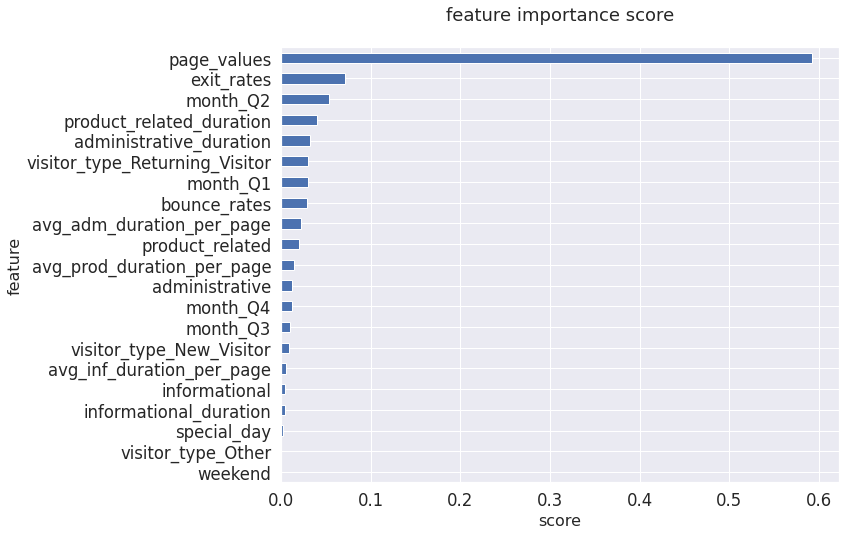

In [106]:
def show_feature_importance(model, features):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score', fontsize=16)
    plt.ylabel('feature', fontsize=16)
    plt.title('feature importance score\n', fontsize=18)
   
X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=False)
clf = classifier()['RandomForestClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)
model.fit(X_train, y_train)
sns.set(font_scale=1.5) 
show_feature_importance(model[-1], X_test.columns)

5 feature dengan importance score tertinggi yaitu 
* page_values
* exit_rates
* month_Q2
* product_related_duration
* administrative_duration

page_values sangat berpengaruh ke model dan nilainya sangat tinggi (> 0.5) jika dibandingkan dengan feature-feature lain. Feature-feature tersebut akan digunakan untuk men-train ulang model.

## 3.7 Insights dari feature importance dan rekomendasi aksi

**1. page_values**

Page values merupakan nilai rata-rata untuk halaman yang dikunjungi pengguna sebelum menyelesaikan konversi atau transaksi eCommerce (ref). Berdasarkan feature importance, dapat dilihat bahwa page values memiliki pengaruh yang signifikan terhadap konversi. Sesi dengan page values yang tinggi cenderung menghasilkan revenue, sehingga untuk menghasilkan peningkatan pada purchase/conversion rate, kita juga perlu meningkatkan page values. Salah satu caranya adalah dengan meningkatkan jumlah trafik yang berkualitas. Lakukan pengecekan: halaman mana yang memiliki traffic yang tinggi, tetapi page values nya rendah, lalu optimalkan konten dan interface dari halaman tersebut, sehingga memperbesar kemungkinan customer akan melakukan pembelian.

**2. month_Q2**

Dalam strategi marketing, pemilihan waktu yang tepat untuk memberikan promo atau voucher diskon juga penting. Cek event-event tertentu dari suatu bulan yang memungkinkan peningkatan jumlah user yang belanja. Dari dataset dengan asumsi ecommerce ini aktivitasnya berkegiatan di US, bulan pada Q2 yang memiliki conversion terbanyak adalah May (Mother’s day) - source. Dengan memprediksi mana customer yang akan membeli dan mana yang tidak, kita bisa melakukan aksi berupa pemberian voucher diskon khusus event tertentu kepada customer yang diprediksi tidak membeli, sehingga jadinya membeli. Untuk lebih meminimalisir cost bisa juga memberi voucher untuk pembelian produk yang kemungkinan banyak dibutuhkan pada event tersebut atau pada bulan tersebut (misal: produk coklat saat valentine, kotak kado di libur natal, etc)

**3. exit_rates**

Sesi yang menghasilkan pendapatan cenderung memiliki exit rate yang lebih rendah dibandingkan yang tidak menghasilkan revenue. Sehingga untuk meningkatkan conversion rate/purchase rate, diperlukan aksi yang dapat membantu mengoptimalisasi exit rate. Lakukan pengecekan halaman mana dari ecommerce yang memiliki exit rates paling tinggi. Lalu lakukan optimalisasi. Jika ternyata halaman yang memiliki exit rates tinggi adalah halaman produk, atau halaman check out, lakukan lagi pengecekan kenapa user tidak melanjutkan proses conversi. Apakah karena harga, atau waktu tertentu yang tidak tepat untuk membeli suatu barang.

**4. product_related_duration**

Bila dilihat dari seluruh transaksi yang menghasilkan revenue, sebagian besar adalah berasal dari visit ke product page. Durasi kunjungan ke product page cukup berpengaruh terhadap konversi. Namun, 90% total kunjungan product page dibandingkan dengan 15% sesi yang menghasilkan conversion, terbilang rendah. Sehingga sama dengan rekomendasi pada exit rates, kita perlu melakukan pengecekan terhadap product related page dari segi interface, kemudahan akses, kejelasan informasi dan demonstrasi produk, dll. Apakah high product page visit tapi low conversion disebabkan oleh hal-hal tersebut.

**5. administrative_duration**

Dari sisi domain knowledge, durasi kunjungan ke administrative page seharusnya tidak berperan dalam peningkatan jumlah konversi. Namun dari feature importance, administrative duration termasuk salah satu feature yang memiliki pengaruh yang cukup tinggi ke model, dimana dari sesi yang menghasilkan transaksi, sebagian besar memiliki kunjungan ke administrative page. Perlu di cek apakah user yang melakukan konversi dan memiliki kunjungan ke administrative page merupakan proses UAT atau bukan. Asumsi: administrative page adalah admin user page (dashboard).

## 3.8 Feature Selection

In [66]:
X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=False)
selected_features = [
    "page_values",
    "exit_rates",
    "month_Q2", # to be rechecked
    "product_related_duration",
    "administrative_duration",
]
clf = classifier()['RandomForestClassifier']
model = imblearn_pipeline(
    SMOTE(sampling_strategy='all', random_state=0), 
    clf
)

print("all features")
model.fit(X_train, y_train)
display(model_evaluation(model, X_test, y_test, dataset='Test'))

print(f"\nuse {len(selected_features)} features:{selected_features}")
model.fit(X_train[selected_features], y_train)
display(model_evaluation(model, X_test[selected_features], y_test, dataset='Test'))

all features


{'Accuracy (Test set)': 0.889,
 'F0.5 (Test set)': 0.642,
 'F1 (Test set)': 0.69,
 'Precision (Test set)': 0.613,
 'ROC AUC (Test set)': 0.924,
 'Recall (Test set)': 0.788,
 'model': 'randomforestclassifier'}


use 5 features:['page_values', 'exit_rates', 'month_Q2', 'product_related_duration', 'administrative_duration']


{'Accuracy (Test set)': 0.884,
 'F0.5 (Test set)': 0.63,
 'F1 (Test set)': 0.677,
 'Precision (Test set)': 0.602,
 'ROC AUC (Test set)': 0.911,
 'Recall (Test set)': 0.772,
 'model': 'randomforestclassifier'}

**Pengamatan**
* Apabila menggunakan 5 atau 9 features dengan importance paling tinggi, nilai precision dan ROC AUC lebih rendah dibandingkan dengan memakai semua features

# Git

**Repository for Final Project**

https://github.com/irfan-fadhlurrahman/online-shoppers-purchasing-intention

# Appendix

In [108]:
# preprocessed data
X_train, X_test, y_train, y_test = preprocessed_data(full_train, test, numerical, categorical, is_linear=False)

Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy='all')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=7, random_state=0))])

## Confusion Matrix (Random Forest)

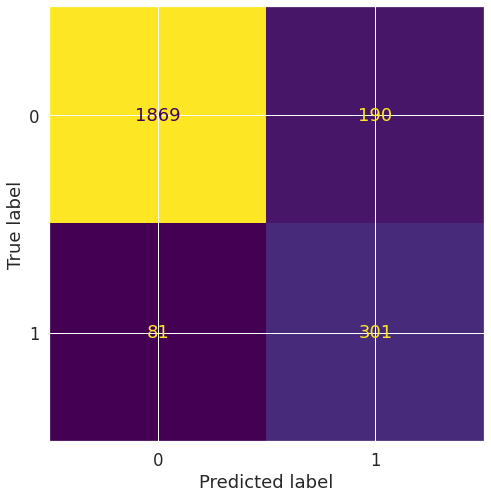

In [109]:
from sklearn.metrics import plot_confusion_matrix
    
# pipeline for the resampler and classifier
model = imblearn_pipeline(
  SMOTE(sampling_strategy='all', random_state=0), 
  classifier()['RandomForestClassifier']
)
model.fit(X_train, y_train)

# specify probability thresholds
threshold = 0.5
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# confusion matrix
plot_confusion_matrix(model, X_test, y_test, colorbar=False)

## SHAP

### Random Forest

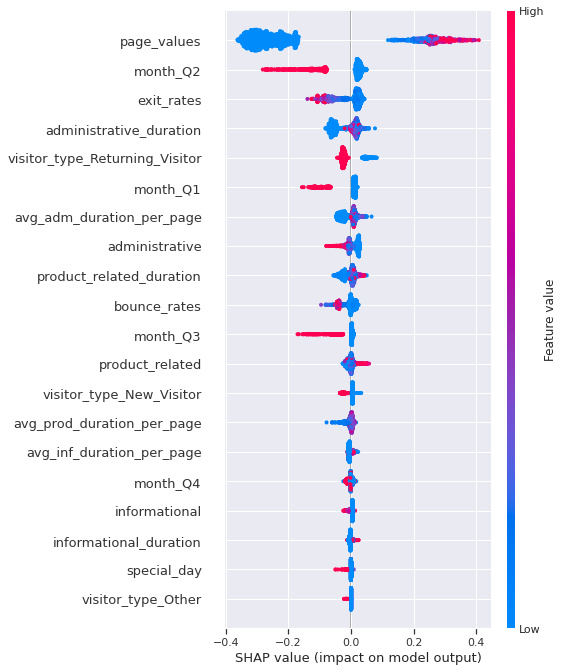

In [ ]:
# pipeline for the resampler and classifier
model = imblearn_pipeline(
  SMOTE(sampling_strategy='all', random_state=0), 
  classifier()['RandomForestClassifier']
)
model.fit(X_train, y_train)

# explainer for model
explainer = shap.TreeExplainer(model[-1])
shap_val = explainer.shap_values(X_test)

# summary barplot
shap.initjs()
shap.summary_plot(shap_val[1], X_test)

### Decision Tree

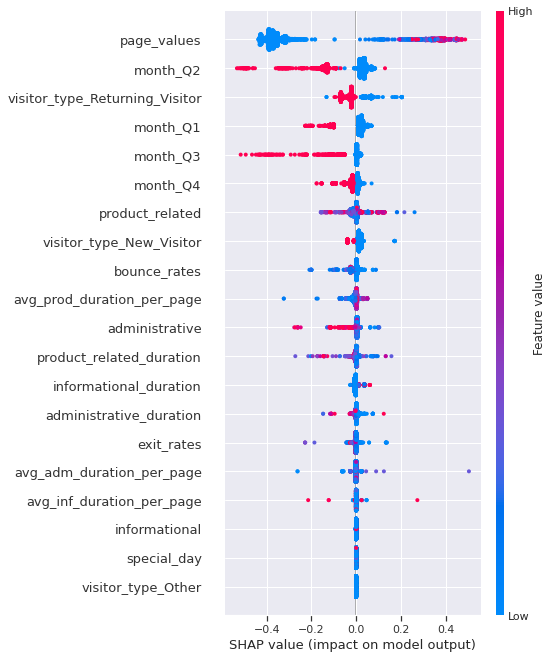

In [110]:
# pipeline for the resampler and classifier
model = imblearn_pipeline(
  SMOTE(sampling_strategy='all', random_state=0), 
  classifier()['DecisionTreeClassifier']
)
model.fit(X_train, y_train)

# explainer for model
explainer = shap.TreeExplainer(model[-1])
shap_val = explainer.shap_values(X_test)

# summary barplot
shap.initjs()
shap.summary_plot(shap_val[1], X_test)